# Libs, data, functions

## Libraries

In [61]:
!pip install mne

In [62]:
!pip install neurodsp

In [63]:
# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
# MNE
import mne.time_frequency
# Other
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import iirdesign
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.interpolate import interp1d
import mne
import math
import bisect
import h5py
from tqdm import tqdm
import os

## Frequency bands

In [64]:
# Frequency bands
noise_band = [0,0.5]
delta_band = [0.5,5]
theta_band = [6,10]
sigma_band = [11,17]
beta_band = [22,30]
gamma_band = [35,45]
total_band = [0,30]



## Functions



### EMG function

In [65]:
def compute_emg_buzsakiMethod(x, y, sig1, sig2, smoothWindow, matfilename):
    """
    The input of this function:
    x --> is the target sampling of the EMG
    y --> is the sampling frequency of the data
    sig1 --> the signal of the first channel
    sig2 --> the signal of the second channel
    smooth --> the smoothing window for the EMG data
    matfilename --> the name of the saved matrix
    """
    binScootS = 1 / x
    binScootSamps = round(y * binScootS)

    # 2. Filter the signal in the high frequency range
    # Filter first in high frequency band to remove low-freq physiologically
    # correlated LFPs (e.g., theta, delta, SPWs, etc.)
    maxfreqband = int(min(625, y / 2))
    xcorr_freqband = [275, 300, maxfreqband - 25, maxfreqband-0.0000001]  # Hz
    filteredSig1 = filtsig_in(sig1, y, xcorr_freqband)[0]
    filteredSig2 = filtsig_in(sig2, y, xcorr_freqband)[0]

    # 3. The relevant parameters important for further correlation analysis
    xcorr_window_samps = round(binScootS * y)
    xcorr_window_inds = np.arange(-xcorr_window_samps, xcorr_window_samps + 1)
    timestamps = np.arange(xcorr_window_inds[-1], sig1.shape[0] - xcorr_window_inds[-1], binScootSamps)
    numbins = len(timestamps)
    EMGCorr = np.zeros(numbins)
    c1, c2 = [], []
    binind, binindstart = -1, 0

    # Loop through different windows
    for i in range(numbins):
        binind += 1
        s1 = []
        s2 = []
        for k in (timestamps[i] + xcorr_window_inds):
          s1.append(filteredSig1[k])
          s2.append(filteredSig2[k])
        c1.append(s1)
        c2.append(s2)
        binindend = binind
        tmp = np.corrcoef(c1, c2)[0, 1]
        EMGCorr[binindstart:(binindend+1)] += tmp
        c1, c2 = [], []
        binindstart = binind + 1

    EMGCorr = EMGCorr/(2 * (2 - 1) / 2)
    EMGNorm = bz_NormToRange(EMGCorr, [0, 1])

    # Making the final structure of the EMG
    EMGFromLFP = {
        'timestamps': timestamps / y,
        'data': EMGCorr,
        'Norm': EMGNorm,
        'channels': 'HPC and PFC',
        'detectorName': 'bz_EMGFromLFP',
        'samplingFrequency': x
    }

    # Smoothing the EMG data
    dtEMG = 1 / EMGFromLFP['samplingFrequency']
    EMGFromLFP['smoothed'] = savgol_filter(EMGFromLFP['data'], window_length=smoothWindow, polyorder=4)

    # Saving the data matrix
    np.save(matfilename, EMGFromLFP)
    return EMGFromLFP

def filtsig_in(sig, Fs, filtband_or_Filt):
    """
    [filt_sig, Filt] = filtsig(sig, dt_ms, filtband_or_Filt)
    Created by: Erik Schomburg, 2011
    """
    if isinstance(filtband_or_Filt, (list, np.ndarray)):
        b, a = iirdesign(wp=[filtband_or_Filt[1], filtband_or_Filt[2]], ws=[filtband_or_Filt[0], filtband_or_Filt[3]], gpass=1, gstop=60, fs=Fs)
        Filt = (b, a)
    else:
        Filt = filtband_or_Filt

    if sig is not None:
        if isinstance(sig, list):
            filt_sig = [filtfilt(Filt[0], Filt[1], s) for s in sig]
        elif sig.ndim > 1:
            filt_sig = np.array([filtfilt(Filt[0], Filt[1], s) for s in sig.T]).T
        else:
            filt_sig = filtfilt(Filt[0], Filt[1], sig)
    else:
        filt_sig = []

    return filt_sig, Filt

def bz_NormToRange(data, newrange):
    """
    Normalize data to a new range
    """
    a, b = newrange
    x = data.copy()
    xmin, xmax = x.min(), x.max()
    return a + (x - xmin) * (b - a) / (xmax - xmin)

### Power extraction function

In [66]:
# Using MNE's multitapering (~3-4min)

def psd_multitaper(lfp_data, fs, frequency_band):
    all_power_sum = []

    # loop through each segment
    for start in range(0, len(lfp_data) - window_length + 1, window_length):
        window = lfp_data[start:min(start + window_length, len(lfp_data))]

        # compute power spectral density using multitaper method
        psd, freqs = mne.time_frequency.psd_array_multitaper(window, fs, fmin=frequency_band[0], fmax=frequency_band[1], n_jobs=1, verbose = 'warning')

        # compute total power within frequency band
        freq_indices = (freqs >= frequency_band[0]) & (freqs <= frequency_band[1])
        curr_sum = np.sum(psd)
        all_power_sum.append(curr_sum)

    return all_power_sum

### Power ratios functions

In [67]:
def PRnoise(noise, total):
  prnoise = np.array([])
  for i in range(len(noise)):
    value = (noise[i])/total[i]
    prnoise = np.append(prnoise, [value])
  return prnoise

In [68]:
def PRdelta(delta, total):
  prdelta = np.array([])
  for i in range(len(delta)):
    value = (delta[i])/total[i]
    prdelta = np.append(prdelta, [value])
  return prdelta

In [69]:
def PRsigma(sigma, total):
  prsigma = np.array([])
  for i in range(len(sigma)):
    value = (sigma[i])/total[i]
    prsigma = np.append(prsigma, [value])
  return prsigma

### Wei indexes functions

In [70]:
def index_W(delta, gamma, EMG):
  index_w = np.array([])
  for i in range(len(delta)):
    value = (EMG[i]*gamma[i])/delta[i]
    index_w = np.append(index_w, [value])
  return index_w

In [71]:
def index_N(delta, sigma, gamma):
  index_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i])/(gamma[i]**2)
    index_n = np.append(index_n, [value])
  return index_n

In [72]:
def index_R(delta, theta, sigma, EMG):
  index_r = np.array([])
  for i in range(len(delta)):
    value = (theta[i]**3)/(delta[i]*sigma[i]*EMG[i])
    index_r = np.append(index_r, [value])
  return index_r

In [73]:
def index_A(noise, delta, theta, sigma, beta, gamma):
  index_a = np.array([])
  for i in range(len(beta)):
    value = ((2*noise[i]+beta[i])*gamma[i])/(delta[i]+theta[i]+sigma[i]+beta[i]+gamma[i])
    index_a = np.append(index_a, [value])
  return index_a

In [74]:
def Artefact_index(index_A, index_N, index_R):
  artefact_index = np.array([])
  for i in range(len(index_A)):
    value = index_A[i]/(index_N[i]+index_R[i]+index_A[i])
    artefact_index = np.append(artefact_index, [value])
  return artefact_index

In [75]:
def Index_1(delta, gamma, EMG):
  index_1 = np.array([])
  for i in range(len(delta)):
    value = (EMG[i]*gamma[i])/(delta[i])
    index_1 = np.append(index_1, [value])
  return index_1

In [76]:
def Index_2(delta, theta, sigma):
  index_2 = np.array([])
  for i in range(len(delta)):
    value = (sigma[i]*delta[i])/(theta[i])
    index_2 = np.append(index_2, [value])
  return index_2

In [77]:
def Index_3(delta, theta, gamma):
  index_3 = np.array([])
  for i in range(len(delta)):
    value = (theta[i]*gamma[i])/(delta[i])
    index_3 = np.append(index_3, [value])
  return index_3

In [78]:
def Index_4(delta, theta):
  index_4 = np.array([])
  for i in range(len(delta)):
    value = delta[i]/theta[i]
    index_4 = np.append(index_4, [value])
  return index_4

### New indices functions

In [79]:
def nindex_W(theta, gamma, EMG):
  index_w = np.array([])
  for i in range(len(theta)):
    value = EMG[i]*EMG[i]*((gamma[i])/(theta[i]))
    index_w = np.append(index_w, [value])
  return index_w

def nindex_R(delta, theta, sigma, EMG, gamma):
  nindex_r = np.array([])
  for i in range(len(delta)):
    value = ((theta[i]*2)*gamma[i])/(delta[i]*delta[i]*EMG[i]**2)
    nindex_r = np.append(nindex_r, [value])
  return nindex_r

def nindex_N(delta, sigma, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i]*sigma[i]/(EMG_norm[i]*theta[i]*gamma[i]**2))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

def nindex_N2(delta, theta, sigma, EMG, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = (delta[i]*sigma[i]*sigma[i]/(EMG[i]*gamma[i]**2))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

def nindex_N3(delta, theta, sigma, EMG, gamma):
  nindex_n = np.array([])
  for i in range(len(delta)):
    value = ((sigma[i])/(gamma[i]*EMG[i]*gamma[i]*theta[i]))
    nindex_n = np.append(nindex_n, [value])
  return nindex_n

### Wei normalisation

In [80]:
def wei_normalizing(data):
  data = np.array(data)

  bottom = data[data <= np.nanpercentile(data, 10, axis=0) ]
  bottom_avg = np.average(bottom)
  top = data[data >= np.nanpercentile(data, 90, axis=0) ]
  top_avg = np.average(top)
  normalized_data = (data - bottom_avg) / (top_avg - bottom_avg)  # Normalise with [min,max] -> [0,1]
  normalized_data = np.clip(normalized_data, 0.05, 1) # set to 0.05 all negative values, set to 1 all values greater than 1

  return normalized_data

###  Get matrix of new features

In [81]:
def getNewFeatures(raw_hpc, raw_pfc):

  # Getting EMG
  emg_sampling = 5
  smoothWindow = fs
  EMGFromLFP = compute_emg_buzsakiMethod(emg_sampling,fs,raw_pfc,raw_hpc,smoothWindow,'emglikesignal')
  EMG = EMGFromLFP['data']
  emg_mat_norm = EMGFromLFP['Norm']
  emg_mat_smoothed = EMGFromLFP['smoothed']
  if len(EMG) % 2 == 1:
    EMG = np.append(EMG, EMG[-1])
  EMG =EMG[:len(EMG) // (epoch_length*emg_sampling) * (epoch_length*emg_sampling)]
  EMG = EMG.reshape(-1, (epoch_length*emg_sampling))
  EMG = EMG.sum(axis=1)

  # Get mapped scores
  sleep_scoring = np.ravel(states)
  reshaped_scores = sleep_scoring[:len(sleep_scoring) // epoch_length * epoch_length].reshape(-1, epoch_length)
  majority_scores = mode(reshaped_scores, axis=1).mode.flatten()
  score_labels = {0: 'Unknown', 1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
  majority_states = [score_labels[state] for state in majority_scores]
  mapped_scores = np.array(majority_states)
  sleep_time_minutes = np.arange(0, len(majority_scores)) * epoch_length / 60
  num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

  # Get powers
  noise = psd_multitaper(np.ravel(raw_hpc), fs, noise_band)
  delta = psd_multitaper(np.ravel(raw_pfc), fs, delta_band)
  theta = psd_multitaper(np.ravel(raw_hpc), fs, theta_band)
  sigma = psd_multitaper(np.ravel(raw_pfc), fs, sigma_band)
  gamma = psd_multitaper(np.ravel(raw_pfc), fs, gamma_band)

  # Normalize all these powers
  noise_norm = wei_normalizing(noise)
  delta_norm = wei_normalizing(delta)
  theta_norm = wei_normalizing(theta)
  sigma_norm = wei_normalizing(sigma)
  gamma_norm = wei_normalizing(gamma)
  EMG_norm = wei_normalizing(EMG)

  # Get smoothed powers as feature
  noise_smoothed = np.convolve(np.convolve(np.convolve(noise_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  theta_smoothed = np.convolve(np.convolve(np.convolve(theta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  delta_smoothed = np.convolve(np.convolve(np.convolve(delta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

  # Compute new indices
  nindex_w = nindex_W(theta_norm, gamma_norm, EMG_norm)
  nindex_n = nindex_N(delta_norm, sigma_norm, gamma_norm)
  nindex_r = nindex_R(delta_norm, theta_norm, sigma_norm, EMG_norm, gamma_norm)
  index_1 = Index_1(delta_norm, gamma_norm, EMG_norm)
  index_2 = Index_2(delta_norm, theta_norm, sigma_norm)
  index_3 = Index_3(delta_norm, theta_norm, gamma_norm)
  index_4 = Index_4(delta_norm, theta_norm)

  # Take log of indices
  nindex_w_log = np.log(nindex_w)
  nindex_n_log = np.log(nindex_n)
  nindex_r_log = np.log(nindex_r)
  index_1_log = np.log(index_1)
  index_2_log = np.log(index_2)
  index_3_log = np.log(index_3)
  index_4_log = np.log(index_4)

  # Normalise indices
  nindex_w_norm = wei_normalizing(nindex_w_log)
  nindex_n_norm = wei_normalizing(nindex_n_log)
  nindex_r_norm = wei_normalizing(nindex_r_log)
  index_1_norm = wei_normalizing(index_1_log)
  index_2_norm = wei_normalizing(index_2_log)
  index_3_norm = wei_normalizing(index_3_log)
  index_4_norm = wei_normalizing(index_4_log)

  # Smooth indices
  nindex_w_smoothed = np.convolve(np.convolve(np.convolve(nindex_w_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  nindex_n_smoothed = np.convolve(np.convolve(np.convolve(nindex_n_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  nindex_r_smoothed = np.convolve(np.convolve(np.convolve(nindex_r_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  index_1_smoothed = np.convolve(np.convolve(np.convolve(index_1_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  index_2_smoothed = np.convolve(np.convolve(np.convolve(index_2_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  index_3_smoothed = np.convolve(np.convolve(np.convolve(index_3_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
  index_4_smoothed = np.convolve(np.convolve(np.convolve(index_4_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')


  # Create matrix
  new_features = np.column_stack((nindex_w_smoothed, nindex_r_smoothed, nindex_n_smoothed, index_1_smoothed, index_2_smoothed, index_3_smoothed, index_4_smoothed, noise_smoothed, theta_smoothed, delta_smoothed))
  np.save('new_features.npy', new_features)

  return new_features, mapped_scores

### Plot results of new features

In [82]:
def plots(new_features, mapped_scores):

  epochs = np.arange(len(mapped_scores))
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 8))
  # Plot data on each subplot
  ax1.plot(epochs, new_features[:,0], label='Index W', color='black')
  ax1.plot(epochs, new_features[:,2], label='Index N', color='blue')
  ax1.plot(epochs, new_features[:,1], label='Index R', color='red')

  ax1.plot(epochs, new_features[:,0], label='Index W', color='black')
  ax1.plot(epochs, new_features[:,2], label='Index N', color='blue')
  ax1.plot(epochs, new_features[:,1], label='Index R', color='red')

  ax2.plot(epochs, mapped_scores, label='Mapped scores')

  # Add legends
  ax1.legend()
  ax2.legend()
  # Add titles
  ax1.set_title('New indices')
  ax2.set_title('Mapped scores')
  # Adjust layout to avoid overlap
  plt.tight_layout()
  # Show the plots
  plt.show()


  # Barplot
  index_Wake = [[],[],[]]
  index_NREM = [[],[],[]]
  index_REM = [[],[],[]]
  for i, el in enumerate(mapped_scores):

    if el == 'Wake':
      index_Wake[0].append(new_features[:,0][i])
      index_Wake[1].append(new_features[:,1][i])
      index_Wake[2].append(new_features[:,2][i])
    elif el == 'NREM':
      index_NREM[0].append(new_features[:,0][i])
      index_NREM[1].append(new_features[:,1][i])
      index_NREM[2].append(new_features[:,2][i])
    elif el == 'REM':
      index_REM[0].append(new_features[:,0][i])
      index_REM[1].append(new_features[:,1][i])
      index_REM[2].append(new_features[:,2][i])

  wake_w = np.average(index_Wake[0])
  wake_r = np.average(index_Wake[1])
  wake_n = np.average(index_Wake[2])
  NREM_w = np.average(index_NREM[0])
  NREM_r = np.average(index_NREM[1])
  NREM_n = np.average(index_NREM[2])
  REM_w = np.average(index_REM[0])
  REM_r = np.average(index_REM[1])
  REM_n = np.average(index_REM[2])

  if 'Wake' not in mapped_scores:
    nwake_w = 0
    nwake_r = 0
    nwake_n = 0
  if 'REM' not in mapped_scores:
    nREM_w = 0
    nREM_r = 0
    nREM_n = 0
  if 'NREM' not in mapped_scores:
    nNREM_w = 0
    nNREM_r = 0
    nNREM_n = 0

  plt.figure(figsize=(12, 6))
  # Wei indexes
  plt.subplot(1, 2, 1)
  categories = ['Wake', 'NREM', 'REM']
  index_types = ['Index_w', 'Index_r', 'Index_n']
  values_wake = [wake_w, NREM_w, REM_w]
  values_REM = [wake_r, NREM_r, REM_r]
  values_NREM = [wake_n, NREM_n, REM_n]
  x = np.arange(len(categories))
  bar_width = 0.2
  # Create bar plots
  plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
  plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
  plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
  # Add labels and title
  plt.xlabel('Sleep Stages')
  plt.ylabel('Average Index Values')
  plt.title('New indexes')
  plt.xticks(x, categories)
  plt.legend()

  for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

# Test on a post trial

See how spectral powers for different frequency bands evolve with sleep and how they correlate with sleep states in the manual scoring.
Get plots of the features' evolution over time, compared to manual hypnogram. Compare Wei features to our features.

## Loading Data

In [83]:
fs = 250 # EEG sampling frequency
window_length = 30*fs
epoch_length = int(window_length/fs)

In [84]:
raw = mne.io.read_raw_brainvision("D:/Intercranial_sleep_data/2/iEEG/converted_prep/combined_nights/night1.vhdr")
hpc_data = raw.get_data(picks='Oz')[0]
raw_hpc = np.ravel(hpc_data)

Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted_prep/combined_nights/night1.vhdr...
Setting channel info structure...


In [85]:
pfc_data = raw.get_data(picks='Cz')[0]
raw_pfc = np.ravel(pfc_data)

In [86]:
states = np.load("D:/converted_sleep_data/2/combined_nights/edf_files/night1_hypnogram_30s.npy")

In [87]:
len(hpc_data)/(len(np.ravel(states)))

7502.854760250174

In [88]:
len(states)*2

2878

## Get powers and plots


### Get EMG

In [89]:
EMG = raw.get_data(picks='EMG1')[0]
EMG = EMG[:len(EMG)// (epoch_length * fs) * (epoch_length * fs)] 
EMG = EMG.reshape(-1, (epoch_length * fs))
EMG = EMG.sum(axis=1)

### Get mapped scores

In [103]:
sleep_scoring = np.ravel(states)
# reshaped_scores = sleep_scoring[:len(sleep_scoring) // epoch_length * epoch_length].reshape(-1, epoch_length)
# majority_scores = mode(sleep_scor, axis=1).mode.flatten()
score_labels = {0: 'Wake', 1: 'N1', 2:'N2', 3: 'N3', 4: 'REM'}
majority_states = [score_labels[state] for state in sleep_scoring]

mapped_scores = np.array(majority_states)
sleep_time_minutes = np.arange(0, len(sleep_scoring)) * epoch_length / 60
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

In [105]:
epochs = np.arange(len(mapped_scores))
print(epochs)

[   0    1    2 ... 1436 1437 1438]


### Get powers


In [92]:
# Noise (est. 2min)
noise = psd_multitaper(np.ravel(raw_hpc), fs, noise_band)

In [93]:
# Delta (est. 2min)
delta = psd_multitaper(np.ravel(raw_pfc), fs, delta_band)

In [94]:
# Theta (est. 2min)
theta = psd_multitaper(np.ravel(raw_hpc), fs, theta_band)

In [95]:
# Sigma (est. 2min)
sigma = psd_multitaper(np.ravel(raw_pfc), fs, sigma_band)

In [96]:
# Beta (est. 2min)
beta = psd_multitaper(np.ravel(raw_pfc), fs, beta_band)

In [97]:
# Gamma (est. 2min)
gamma = psd_multitaper(np.ravel(raw_pfc), fs, gamma_band)

In [98]:
# Total power (est. 2min)
#total = psd_multitaper(np.ravel(raw_pfc), fs, total_band)

In [106]:
# Normalize all these powers

noise_norm = wei_normalizing(noise)
delta_norm = wei_normalizing(delta)
theta_norm = wei_normalizing(theta)
sigma_norm = wei_normalizing(sigma)
beta_norm = wei_normalizing(beta)
gamma_norm = wei_normalizing(gamma)
#total_norm = wei_normalizing(total)
EMG_norm = wei_normalizing(EMG)

In [107]:
noise_smoothed = np.convolve(np.convolve(np.convolve(noise_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
theta_smoothed = np.convolve(np.convolve(np.convolve(theta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
delta_smoothed = np.convolve(np.convolve(np.convolve(delta_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

### Plots

C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\992797199.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


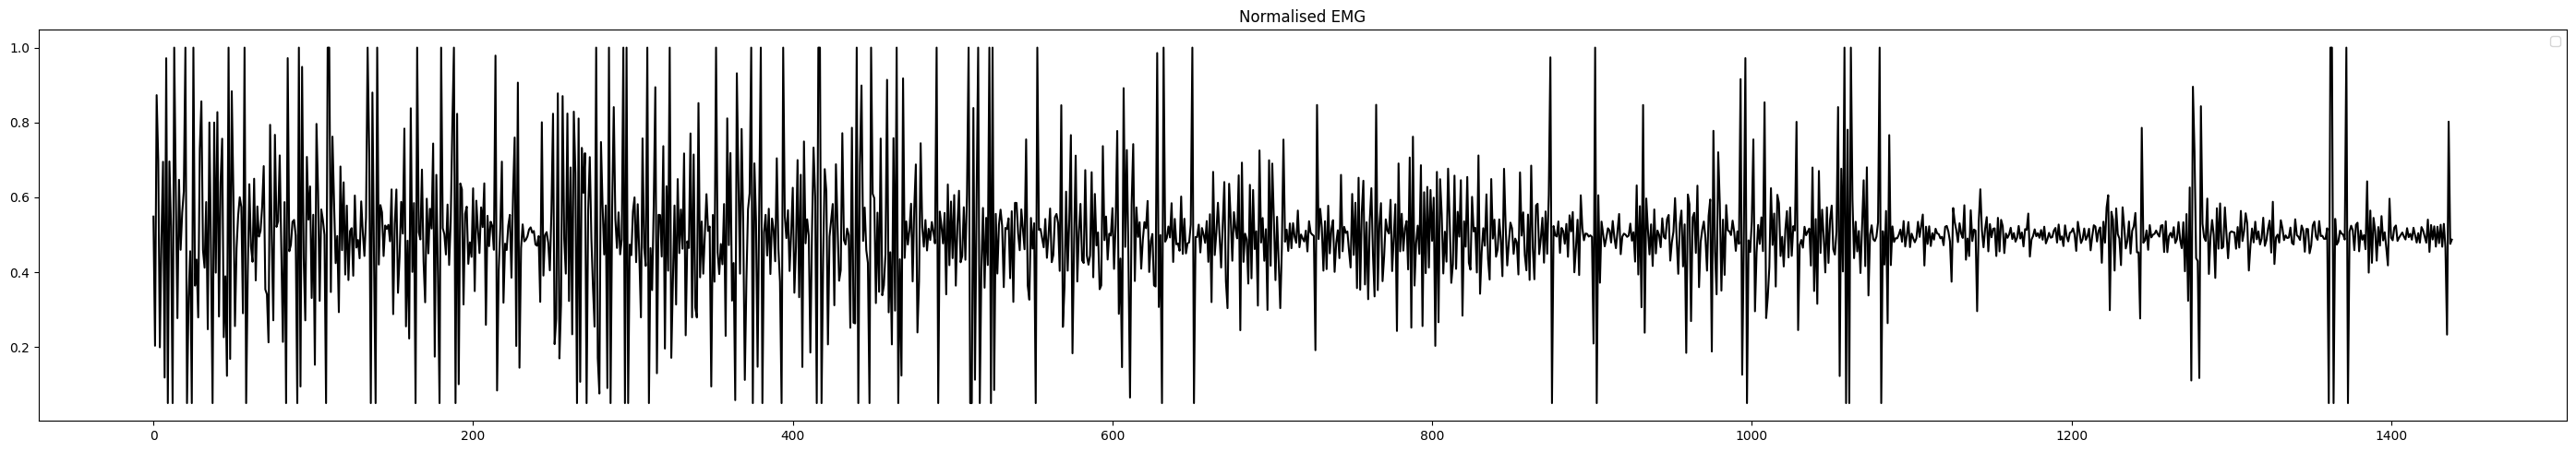

In [110]:

fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize = (28, 5))

# Plot data on each subplot
ax1.plot(epochs, EMG_norm, label='', color = 'black')

# Add legends
ax1.legend()
ax1.set_title('Normalised EMG')
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("Normalised_EMG.svg", format='svg', dpi=300)
# Show the plots
plt.show()

C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\3339865497.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\3339865497.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\3339865497.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()
C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\3339865497.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\timmi\AppData\Local\Temp\ipykernel_30484\3339865497.py:37:

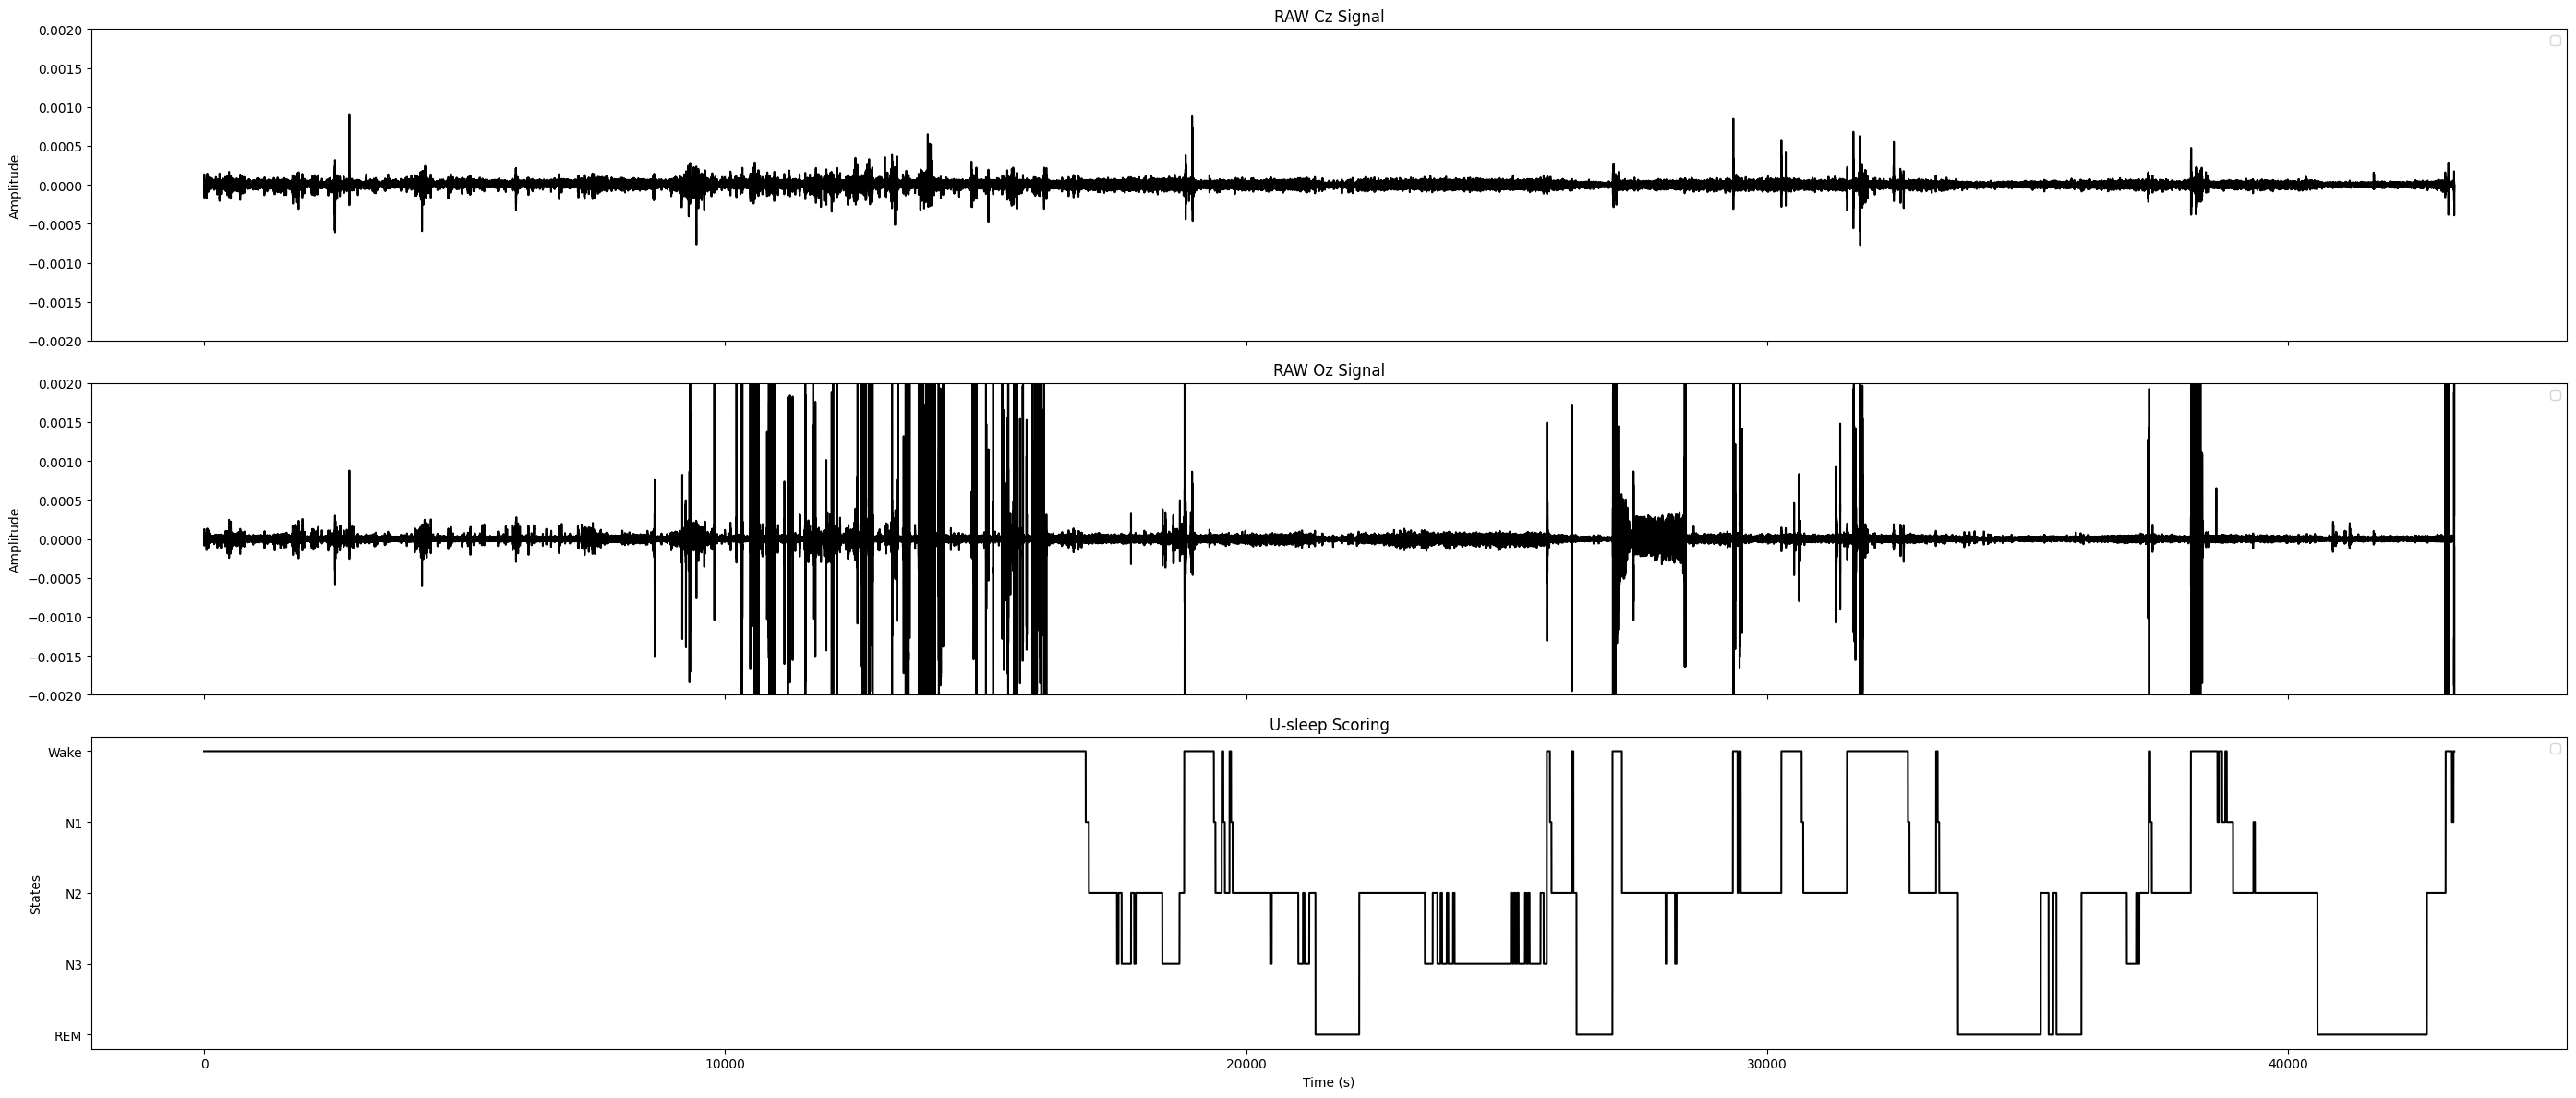

In [125]:
upsampled_states = np.repeat(states, (250*30))
upsampled_states = np.concatenate((upsampled_states, np.zeros(len(raw_hpc)-len(upsampled_states))), axis=0)

x = np.arange(len(raw_hpc))/250

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(28, 12))

# Plot data on each subplot
ax1.plot(x, raw_pfc, label='', color='black')
ax2.plot(x, raw_hpc, label='', color='black')
ax3.plot(x, upsampled_states, label='', color='black')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add axis titles
ax1.set_title('RAW Cz Signal')
ax2.set_title('RAW Oz Signal')
ax3.set_title('U-sleep Scoring')

ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Amplitude')
ax3.set_ylabel('States')
ax3.set_xlabel('Time (s)')
state_labels = ['Wake', 'N1', 'N2', 'N3', 'REM']
ax3.set_yticks([0, 1, 2, 3, 4])
ax3.set_yticklabels(state_labels)
ax3.invert_yaxis() 
# Set y-axis limits (example values, adjust as needed)
ax1.set_ylim(-0.002, 0.002)  # Replace with appropriate limits for your data
ax2.set_ylim(-0.002, 0.002)  # Replace with appropriate limits for your data

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("RAW_signals_Hypnogram.svg", format='svg', dpi=300)
# Show the plots
plt.show()

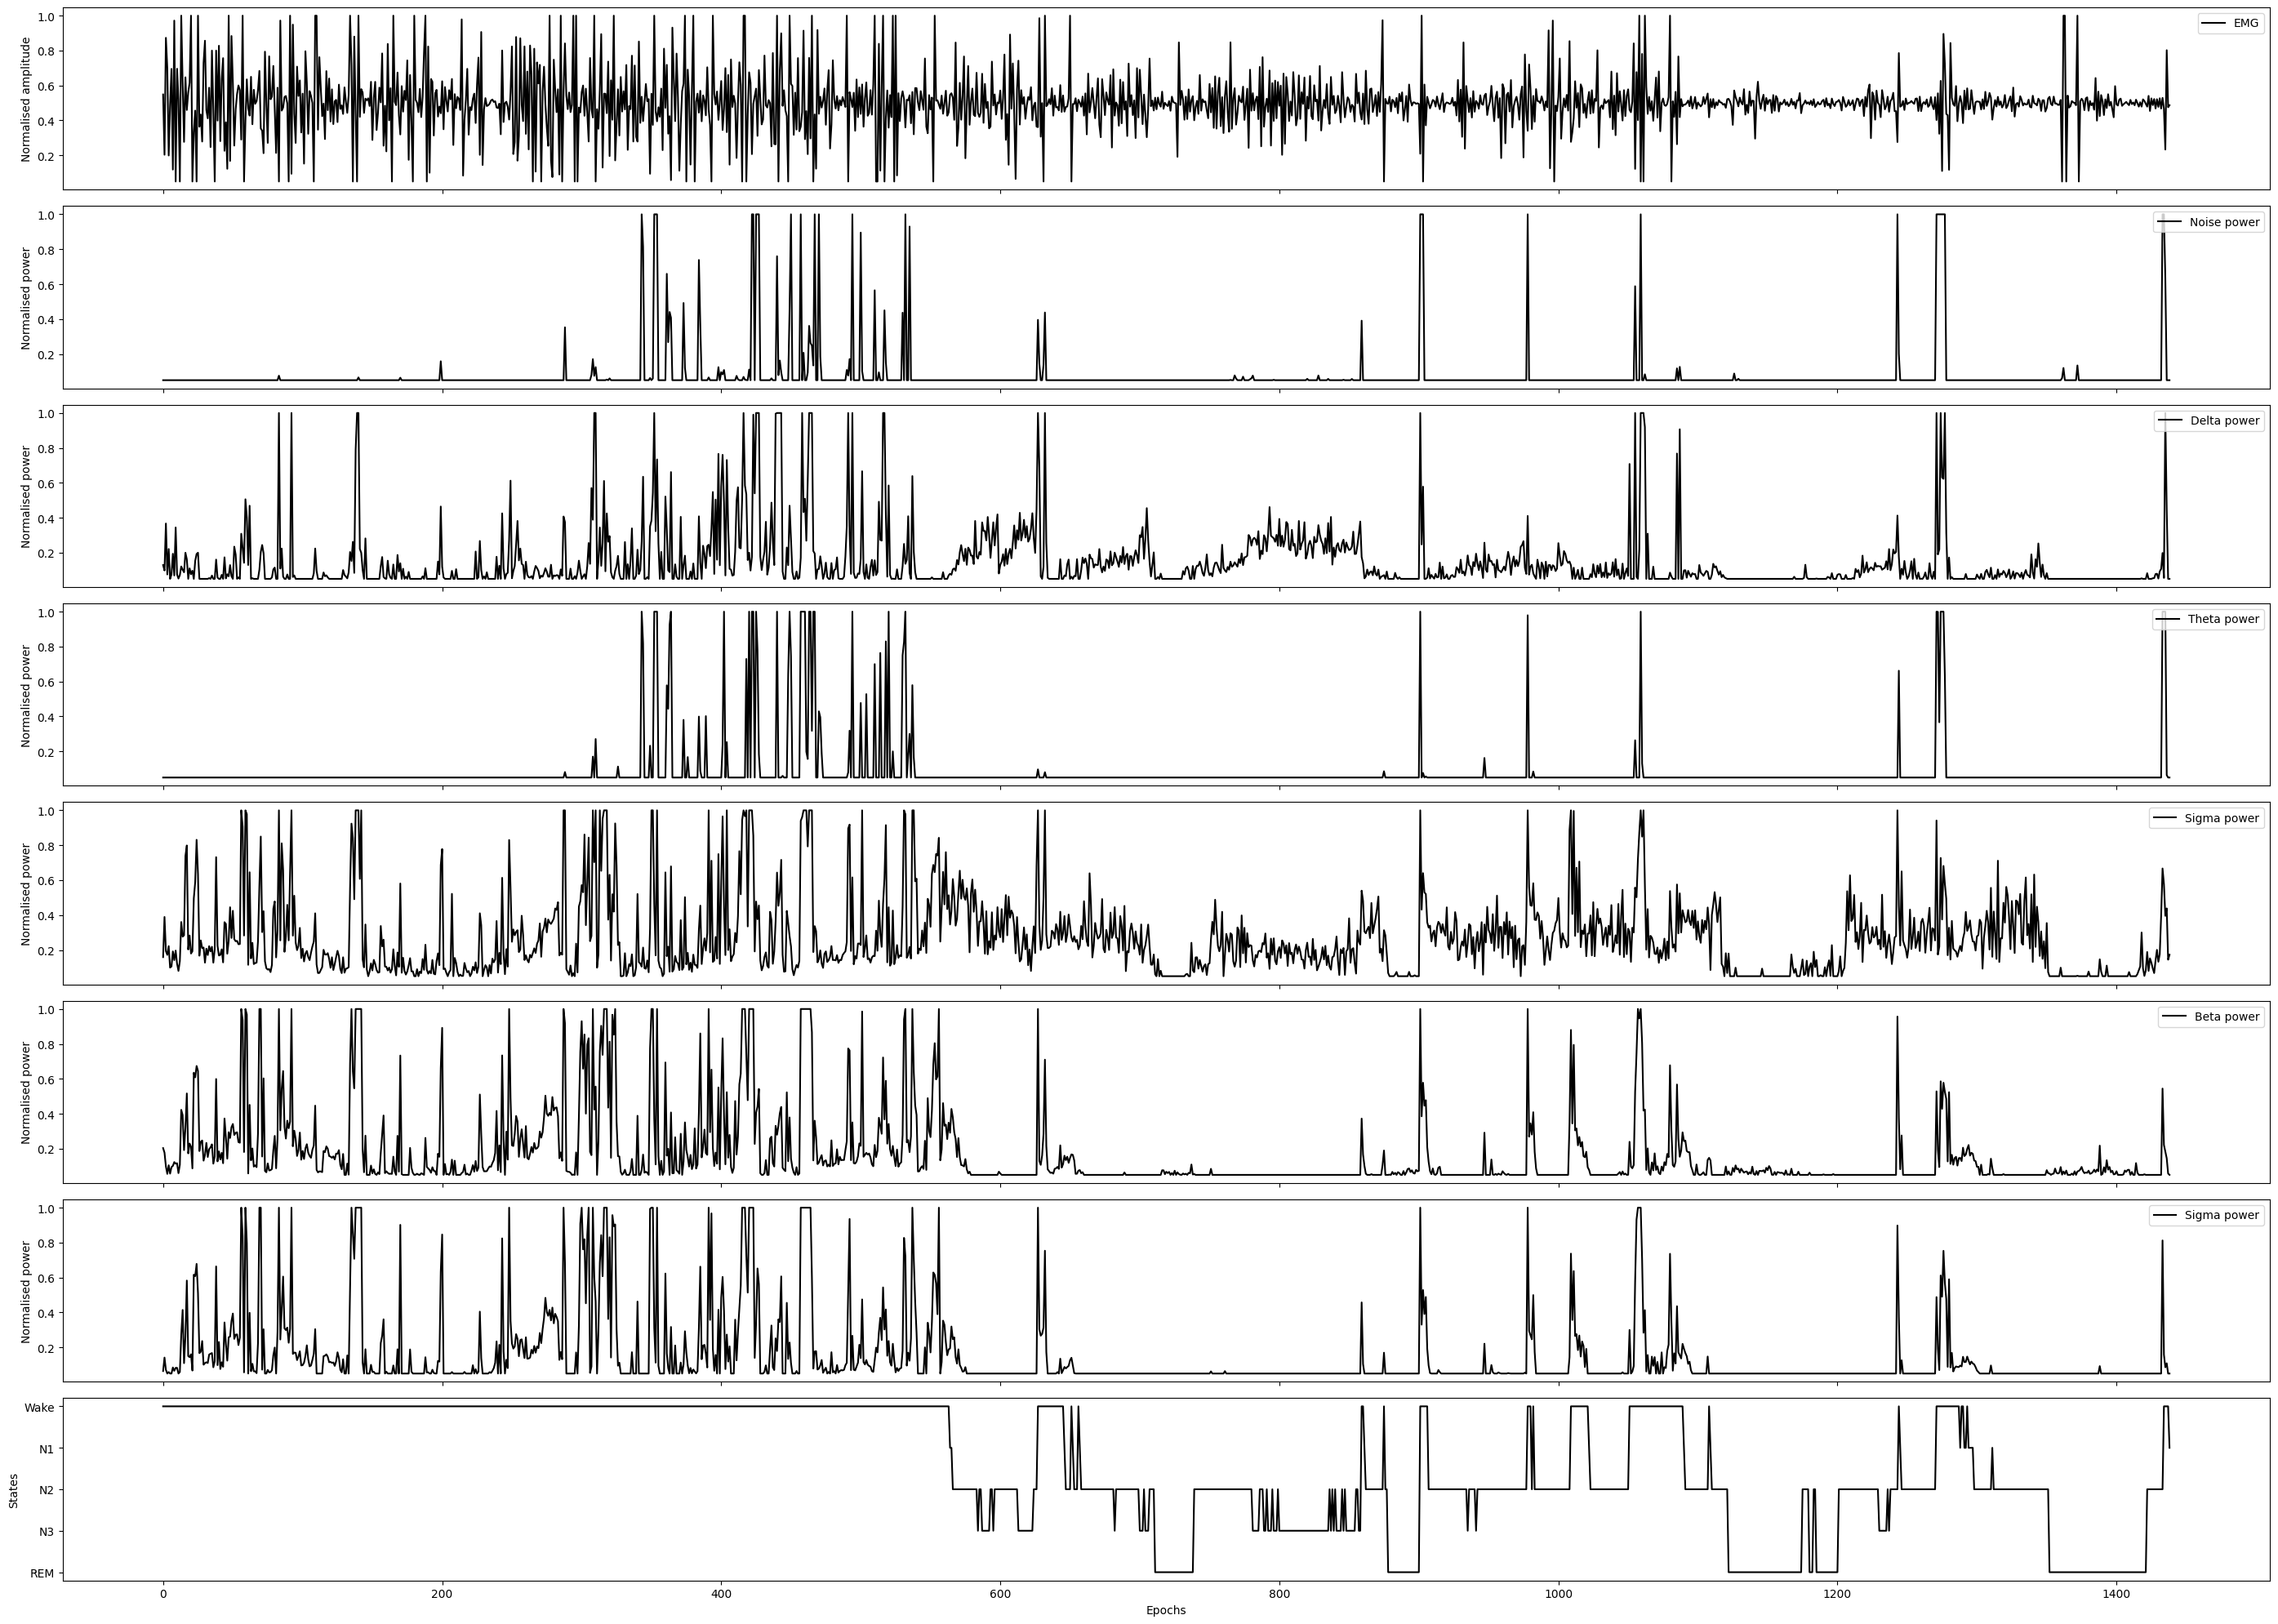

In [128]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, sharex=True, figsize = (28, 20))
epochs = np.arange(len(EMG_norm))
# Plot data on each subplot
ax1.plot(epochs, EMG_norm, label='EMG', color = 'black')
ax2.plot(epochs, noise_norm, label='Noise power', color = 'black')
ax3.plot(epochs, delta_norm, label='Delta power', color = 'black')
ax4.plot(epochs, theta_norm, label='Theta power', color = 'black')
ax5.plot(epochs, sigma_norm, label='Sigma power', color = 'black')
ax6.plot(epochs, beta_norm, label='Beta power', color = 'black')
ax7.plot(epochs, gamma_norm, label='Sigma power', color = 'black')
ax8.plot(epochs, sleep_scoring, label='Mapped scores', color = 'black')


ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
ax5.legend(loc='upper right')
ax6.legend(loc='upper right')
ax7.legend(loc='upper right')

ax1.set_ylabel('Normalised amplitude')
ax2.set_ylabel('Normalised power')
ax3.set_ylabel('Normalised power')
ax4.set_ylabel('Normalised power')
ax5.set_ylabel('Normalised power')
ax6.set_ylabel('Normalised power')
ax7.set_ylabel('Normalised power')
ax8.set_ylabel('States')
ax8.set_yticks([0, 1, 2, 3, 4])
ax8.set_yticklabels(state_labels)
ax8.invert_yaxis() 
ax8.set_xlabel('Epochs')
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("Normalised_powers.svg", format='svg', dpi=300)
# Show the plots
plt.show()

## Indices

### Wei indexes

#### Get indices

In [129]:
# Raw indices

index_w = index_W(delta_norm, gamma_norm, EMG_norm)
index_n = index_N(delta_norm, sigma_norm, gamma_norm)
index_r = index_R(delta_norm, theta_norm, sigma_norm, EMG_norm)
index_1 = Index_1(delta_norm, gamma_norm, EMG_norm)
index_2 = Index_2(delta_norm, theta_norm, sigma_norm)
index_3 = Index_3(delta_norm, theta_norm, gamma_norm)
index_4 = Index_4(delta_norm, theta_norm)

# Taking the log of the indices

index_w_log = np.log(index_w)
index_n_log = np.log(index_n)
index_r_log = np.log(index_r)
index_1_log = np.log(index_1)
index_2_log = np.log(index_2)
index_3_log = np.log(index_3)
index_4_log = np.log(index_4)

# Normalizing the indices

index_w_norm = wei_normalizing(index_w_log)
index_n_norm = wei_normalizing(index_n_log)
index_r_norm = wei_normalizing(index_r_log)
index_1_norm = wei_normalizing(index_1_log)
index_2_norm = wei_normalizing(index_2_log)
index_3_norm = wei_normalizing(index_3_log)
index_4_norm = wei_normalizing(index_4_log)

# Smoothing the indices

index_w_smoothed = np.convolve(np.convolve(np.convolve(index_w_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_n_smoothed = np.convolve(np.convolve(np.convolve(index_n_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_r_smoothed = np.convolve(np.convolve(np.convolve(index_r_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_1_smoothed = np.convolve(np.convolve(np.convolve(index_1_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_2_smoothed = np.convolve(np.convolve(np.convolve(index_2_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_3_smoothed = np.convolve(np.convolve(np.convolve(index_3_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')
index_4_smoothed = np.convolve(np.convolve(np.convolve(index_4_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

#### Save wei features matrix

In [130]:
wei_features = np.column_stack((index_w_smoothed, index_n_smoothed, index_r_smoothed, index_1_smoothed, index_2_smoothed, index_3_smoothed, index_4_smoothed, noise_smoothed, theta_smoothed, delta_smoothed))
#np.save('Wei_features.npy', wei_features)

#### Main indices plots

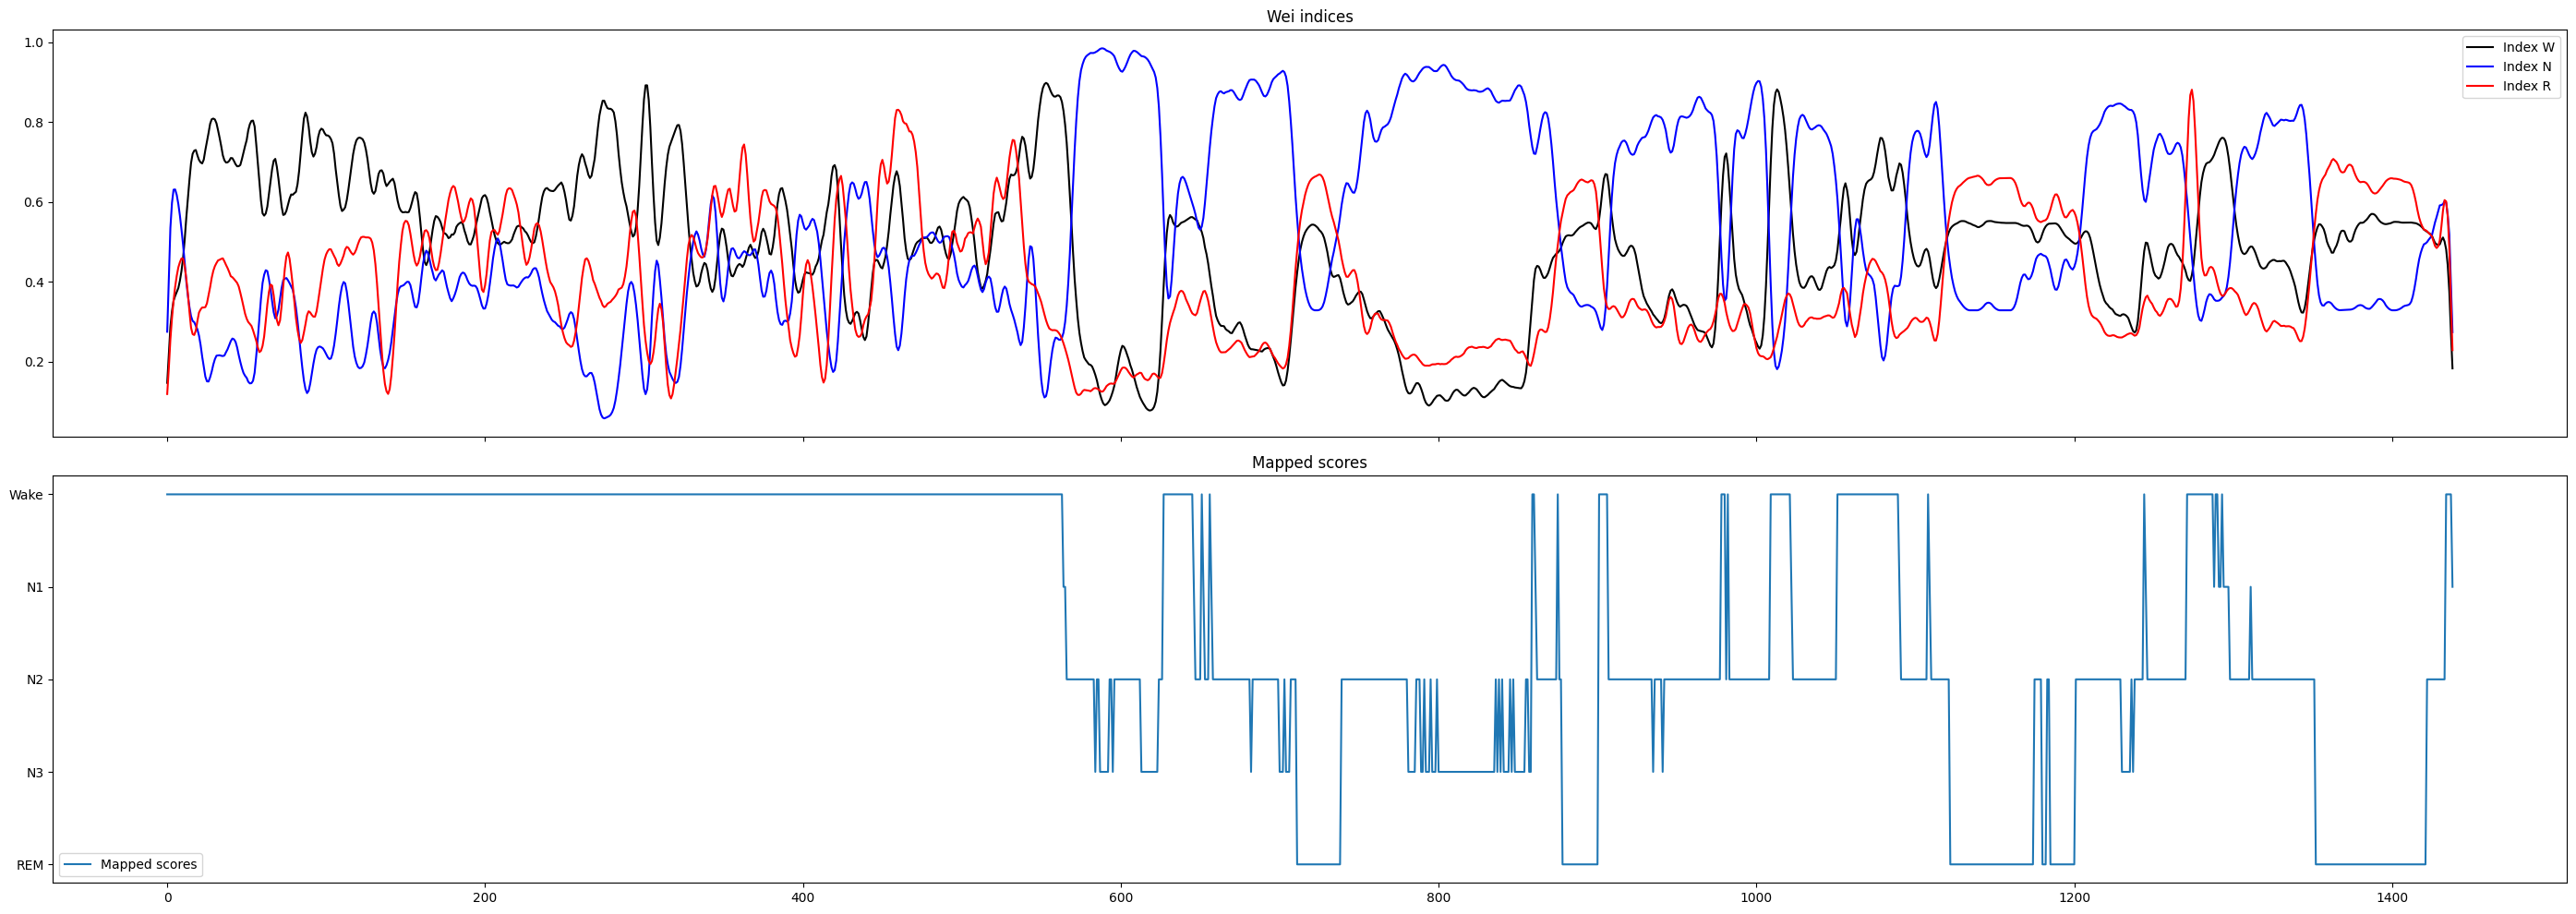

In [133]:
# All main indices

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 10))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color='red')

ax2.plot(epochs, mapped_scores, label='Mapped scores')


# Add legends
ax1.legend()
ax2.legend()


# Add titles
ax1.set_title('Wei indices')
ax2.set_title('Mapped scores')
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_yticklabels(state_labels)
ax2.invert_yaxis() 
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("Wei_indices.svg", format='svg')
# Show the plots
plt.show()

### New indexes

#### New WAKE (define and get index)

##### Compute new index + function

In [134]:
nindex_w = nindex_W(theta_norm, gamma_norm, EMG_norm)
nindex_w_log = np.log(nindex_w)
nindex_w_norm = wei_normalizing(nindex_w_log)
nindex_w_smoothed = np.convolve(np.convolve(np.convolve(nindex_w_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

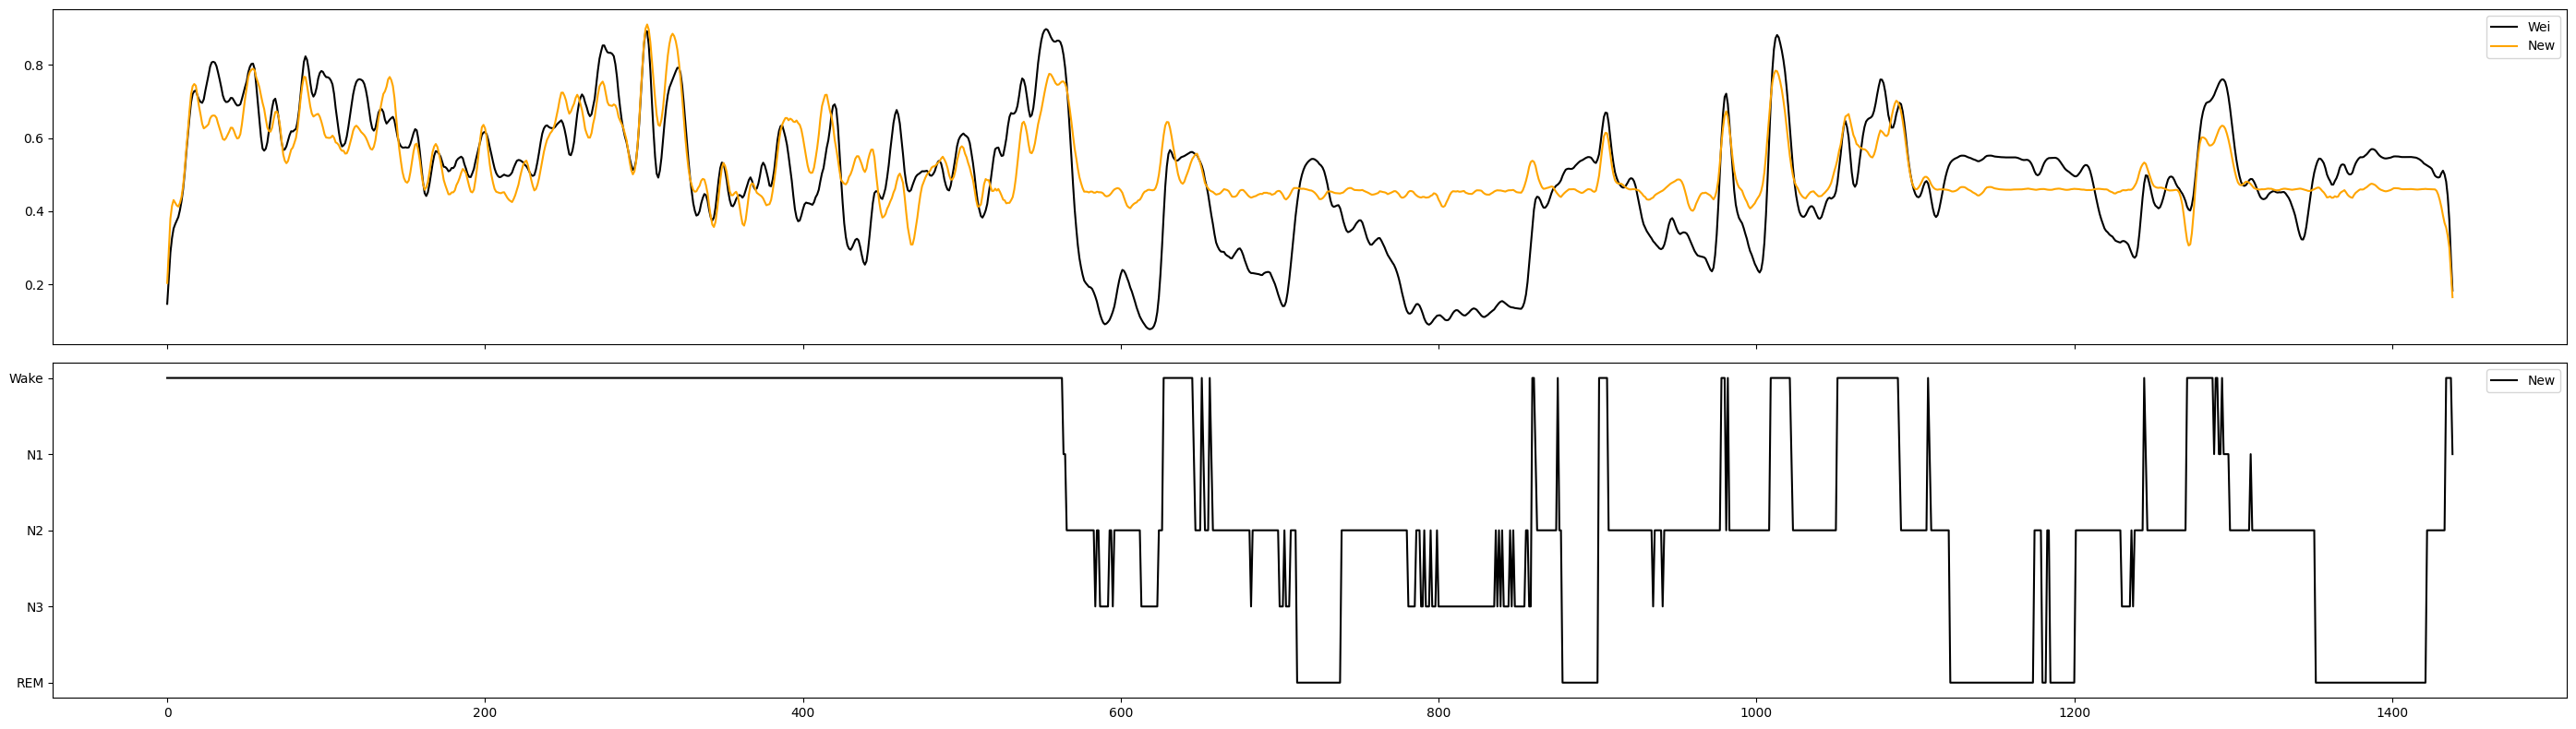

In [136]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Wei', color = 'black')
ax1.plot(epochs, nindex_w_smoothed, label='New', color = 'orange')
ax2.plot(epochs, mapped_scores, label='New', color = 'black')

# Add legends
ax1.legend()
ax2.legend()
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_yticklabels(state_labels)
ax2.invert_yaxis() 
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("new_wake.svg", format='svg')
# Show the plots
plt.show()

##### All indices plot

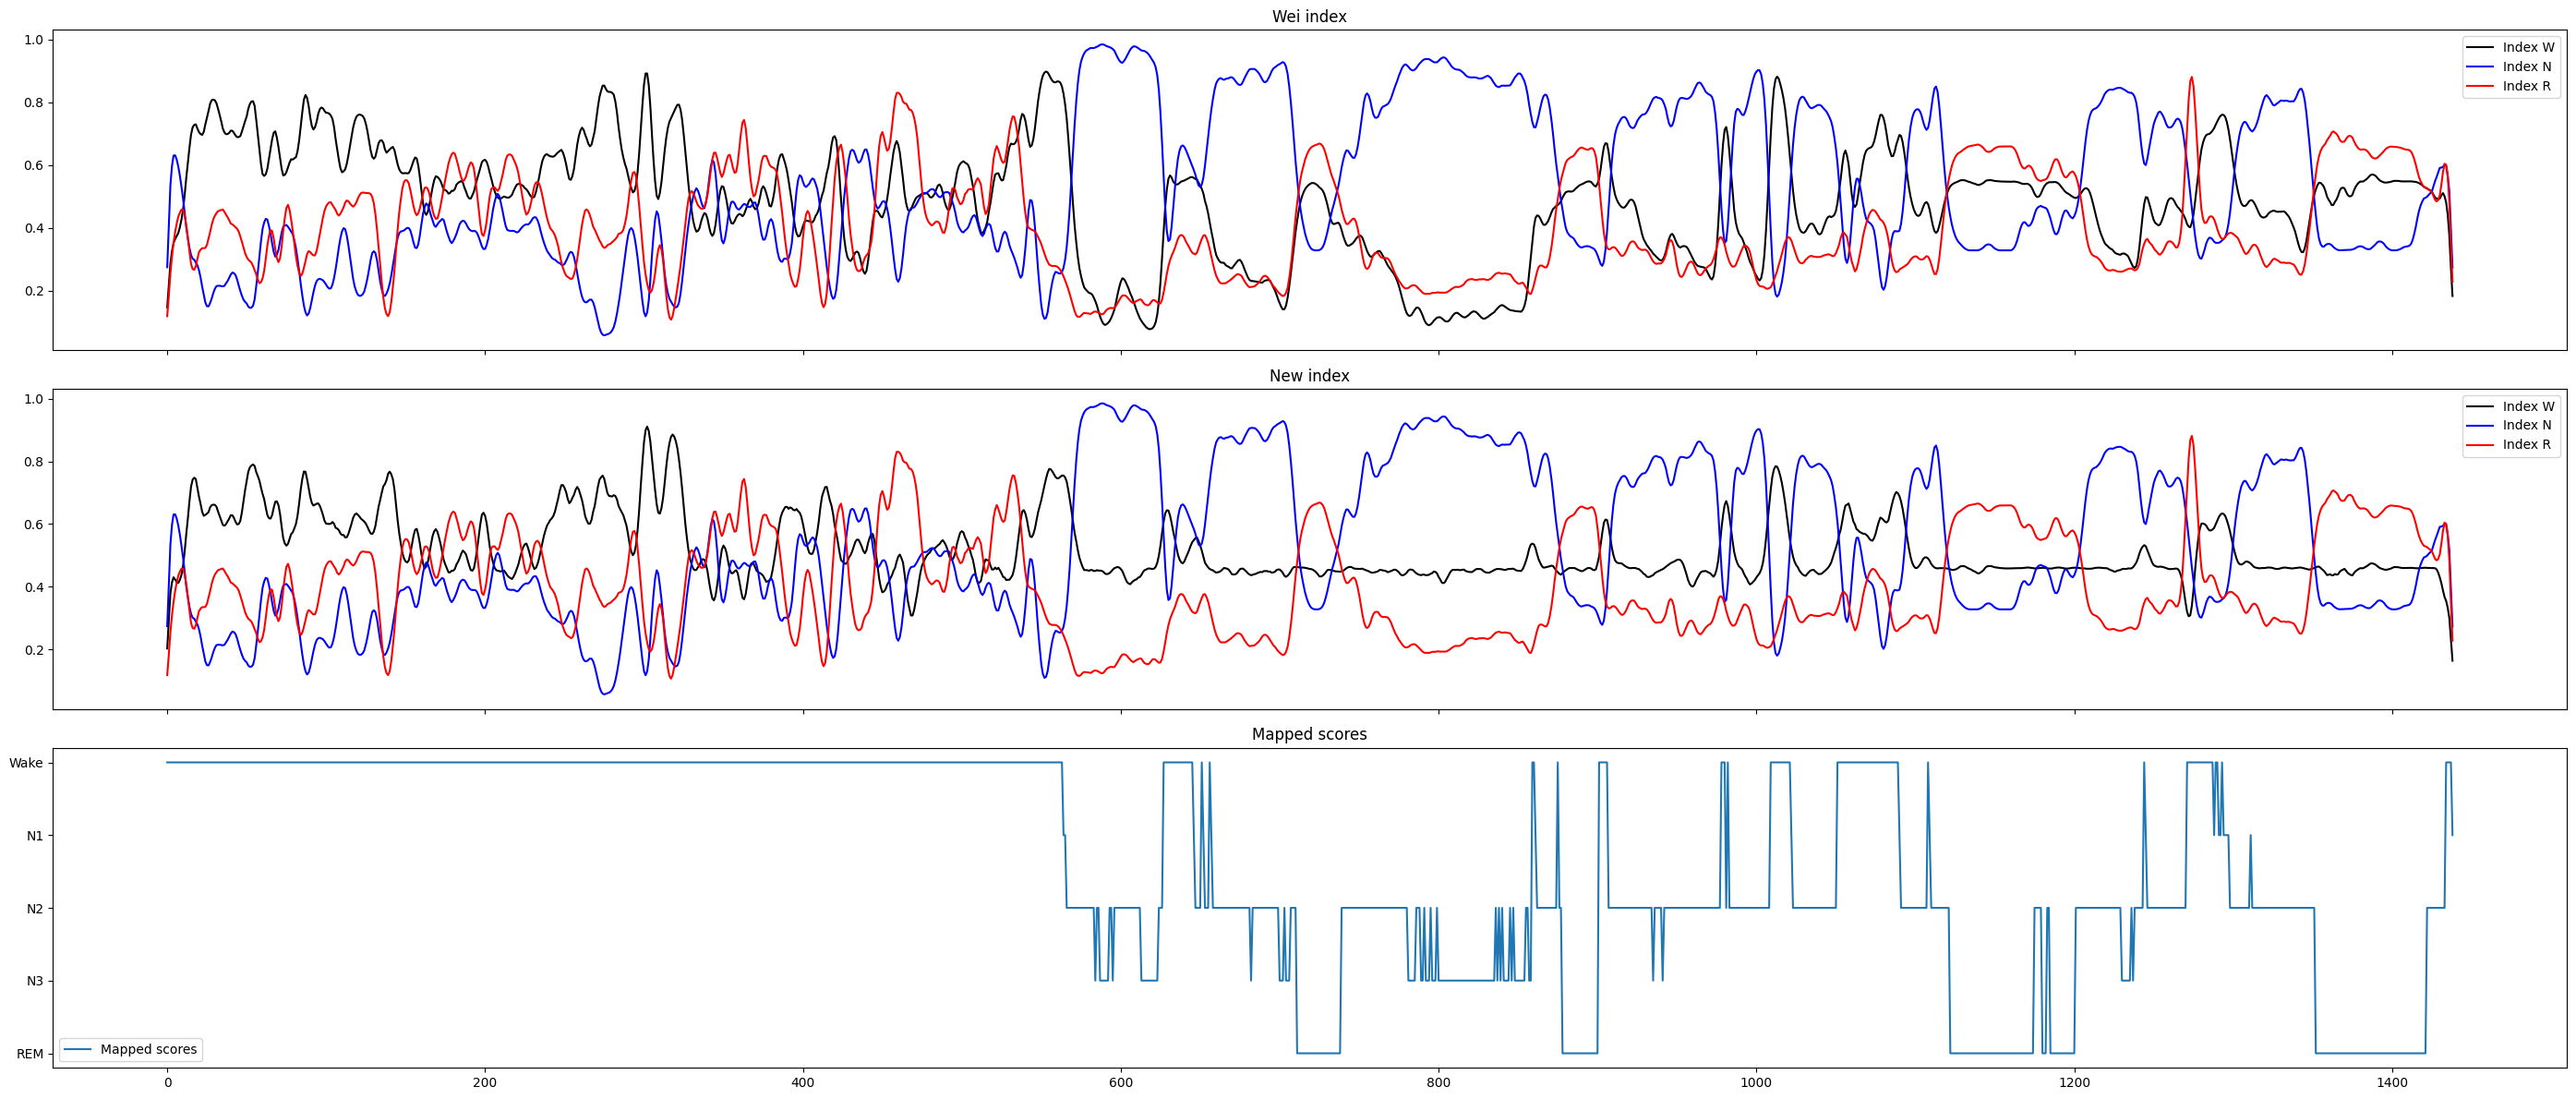

In [138]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, nindex_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, index_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, mapped_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')

ax3.set_yticks([0, 1, 2, 3, 4])
ax3.set_yticklabels(state_labels)
ax3.invert_yaxis() 

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("all_indices.svg", format='svg')
# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [142]:
# Wei
index_Wake = [[],[],[]]
index_n1 = [[],[],[]]
index_n2 = [[],[],[]]
index_n3 = [[],[],[]]
index_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    index_Wake[0].append(index_w_smoothed[i])
    index_Wake[1].append(index_r_smoothed[i])
    index_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    index_n1[0].append(index_w_smoothed[i])
    index_n1[1].append(index_r_smoothed[i])
    index_n1[2].append(index_n_smoothed[i])
  elif el == 'N2':
    index_n2[0].append(index_w_smoothed[i])
    index_n2[1].append(index_r_smoothed[i])
    index_n2[2].append(index_n_smoothed[i])
  elif el == 'N3':
    index_n3[0].append(index_w_smoothed[i])
    index_n3[1].append(index_r_smoothed[i])
    index_n3[2].append(index_n_smoothed[i])
  elif el == 'REM':
    index_REM[0].append(index_w_smoothed[i])
    index_REM[1].append(index_r_smoothed[i])
    index_REM[2].append(index_n_smoothed[i])

# New
nindex_Wake = [[],[],[]]
nindex_n1 = [[],[],[]]
nindex_n2 = [[],[],[]]
nindex_n3 = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(nindex_w_smoothed[i])
    nindex_Wake[1].append(index_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    nindex_n1[0].append(nindex_w_smoothed[i])
    nindex_n1[1].append(index_r_smoothed[i])
    nindex_n1[2].append(index_n_smoothed[i])
  elif el == 'N2':
    nindex_n2[0].append(nindex_w_smoothed[i])
    nindex_n2[1].append(index_r_smoothed[i])
    nindex_n2[2].append(index_n_smoothed[i])
  elif el == 'N3':
    nindex_n3[0].append(nindex_w_smoothed[i])
    nindex_n3[1].append(index_r_smoothed[i])
    nindex_n3[2].append(index_n_smoothed[i])
  elif el == 'REM':
    nindex_REM[0].append(nindex_w_smoothed[i])
    nindex_REM[1].append(index_r_smoothed[i])
    nindex_REM[2].append(index_n_smoothed[i])

In [143]:
# Wei
wake_w = np.average(index_Wake[0])
wake_r = np.average(index_Wake[1])
wake_n = np.average(index_Wake[2])
n1_w = np.average(index_n1[0])
n1_r = np.average(index_n1[0])
n1_n = np.average(index_n1[0])
n2_w = np.average(index_n2[0])
n2_r = np.average(index_n2[0])
n2_n = np.average(index_n2[0])
n3_w = np.average(index_n3[0])
n3_r = np.average(index_n3[0])
n3_n = np.average(index_n3[0])
REM_w = np.average(index_REM[0])
REM_r = np.average(index_REM[1])
REM_n = np.average(index_REM[2])

# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nn1_w = np.average(nindex_n1[0])
nn1_r = np.average(nindex_n1[1])
nn1_n = np.average(nindex_n1[2])
nn2_w = np.average(nindex_n2[0])
nn2_r = np.average(nindex_n2[1])
nn2_n = np.average(nindex_n2[2])
nn3_w = np.average(nindex_n3[0])
nn3_r = np.average(nindex_n3[1])
nn3_n = np.average(nindex_n3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

###### Barplots

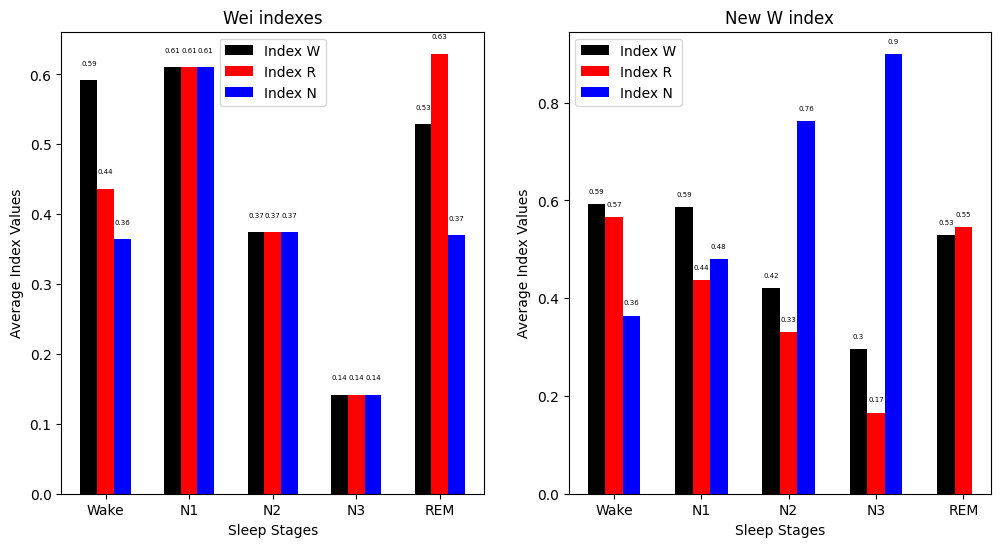

In [165]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', 'N2','N3', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, n1_w, n2_w, n3_w, REM_w]
values_REM = [wake_r, n1_r, n2_r, n3_r, REM_r]
values_NREM = [wake_n, n1_n, n2_n, n3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

fontsize = 5

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom', fontsize=fontsize)

# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', 'N2','N3', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nn1_w, nn2_w, nn3_w, nREM_w]
values_REM = [nwake_r, nn1_r, nn2_r, nn3_r, nREM_r]
values_NREM = [nwake_n, nn1_n, nn2_n, nn3_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New W index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
plt.savefig("wei_newwei_barplot.svg", format='svg')

#### New REM (define and get index)

##### Compute new index + function

In [155]:
nindex_r = nindex_R(delta_norm, theta_norm, sigma_norm, EMG_norm, gamma_norm)
nindex_r_log = np.log(nindex_r)
nindex_r_norm = wei_normalizing(nindex_r_log)
nindex_r_smoothed = np.convolve(np.convolve(np.convolve(nindex_r_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

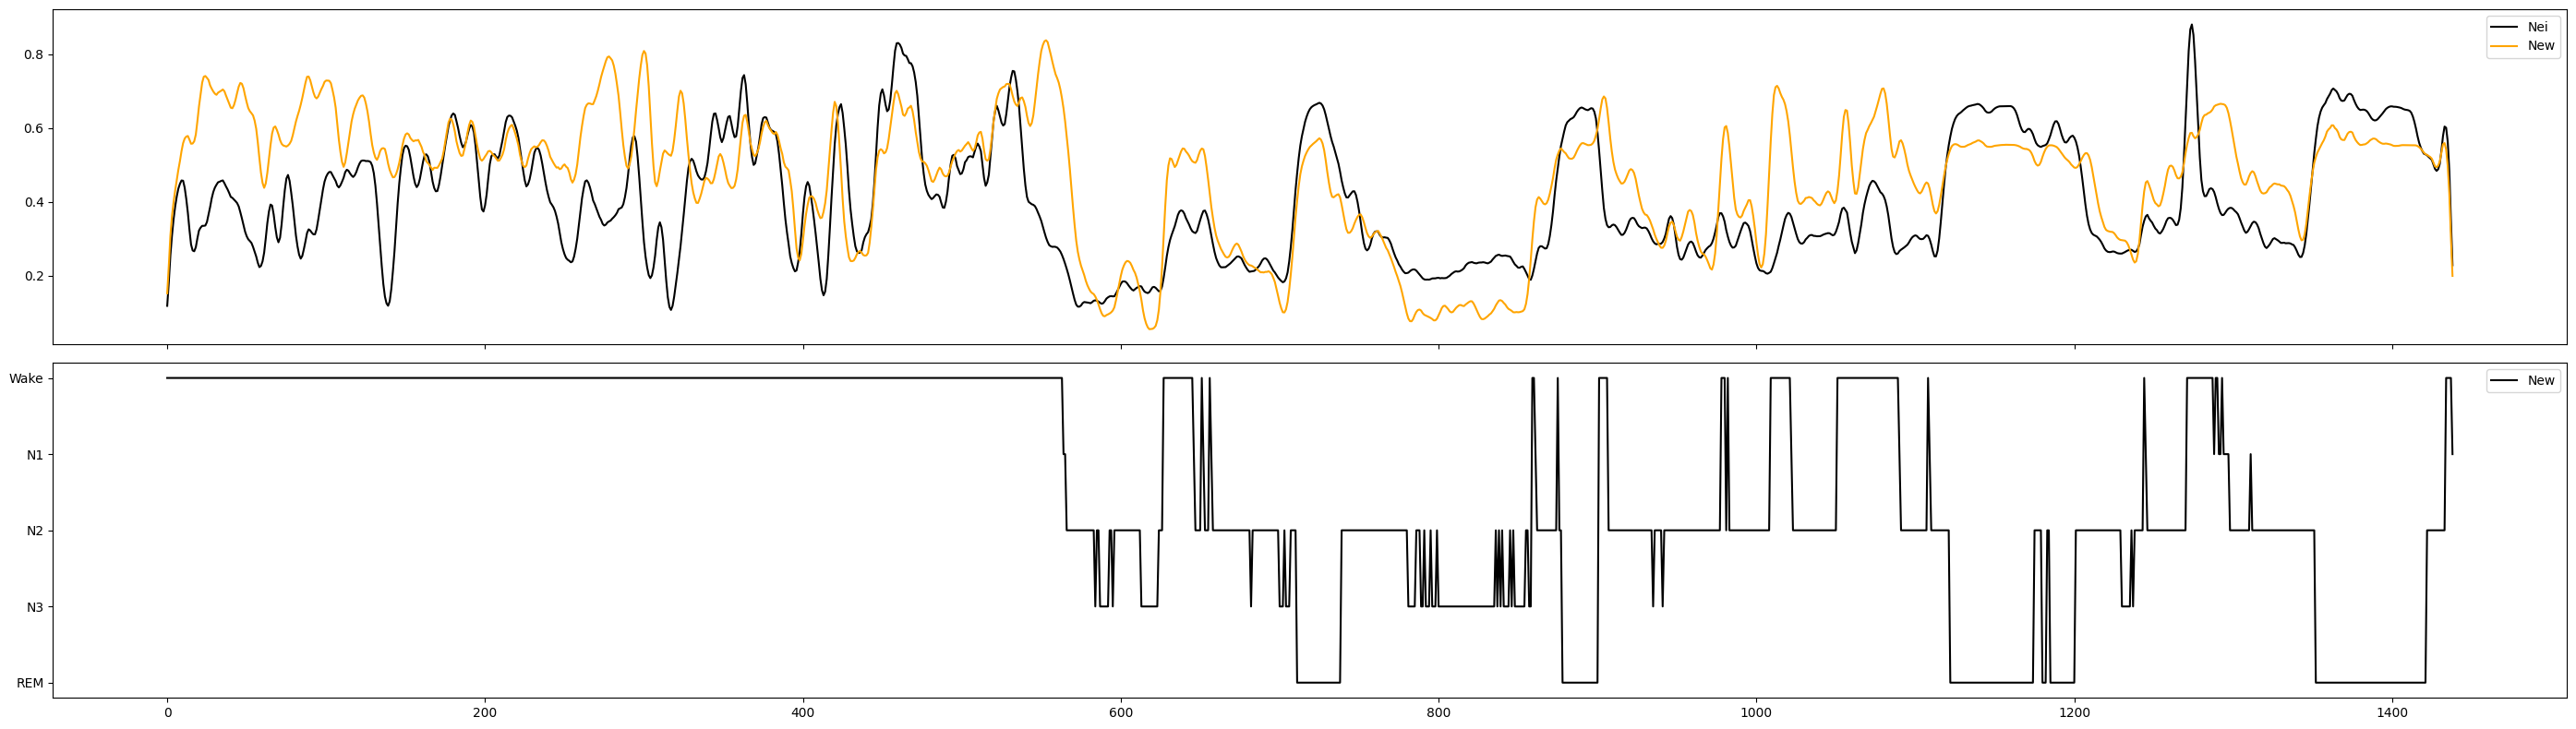

In [161]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_r_smoothed, label='Nei', color = 'black')
ax1.plot(epochs, nindex_r_smoothed, label='New', color = 'orange')
ax2.plot(epochs, mapped_scores, label='New', color = 'black')

# Add legends
ax1.legend()
ax2.legend()
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_yticklabels(state_labels)
ax2.invert_yaxis() 
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("newrem.svg", format='svg')
# Show the plots
plt.show()

##### All indices plot

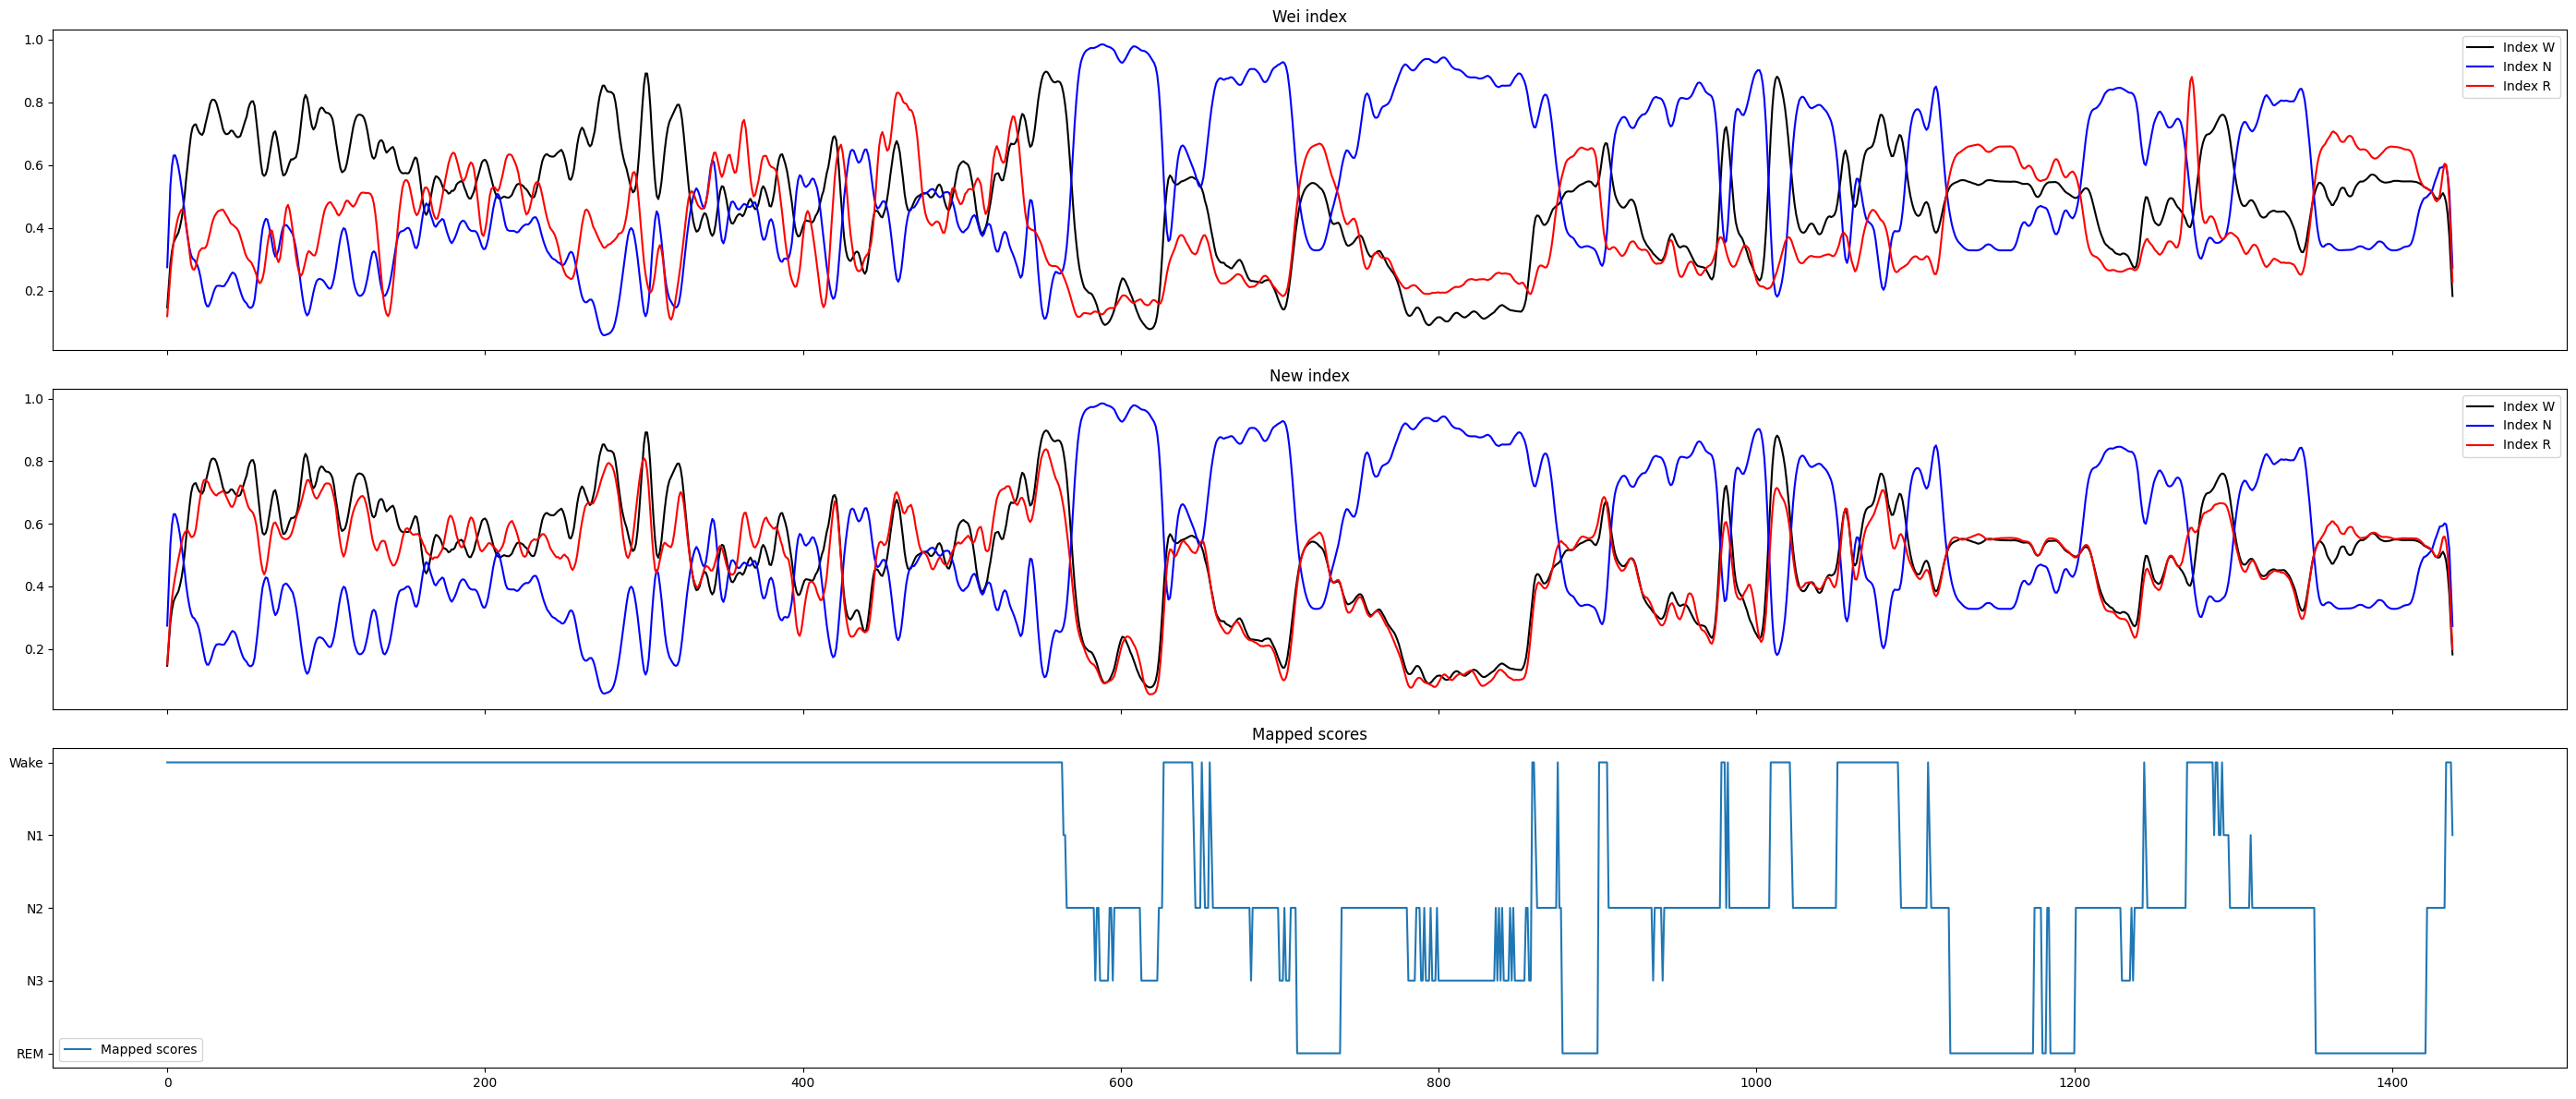

In [160]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, nindex_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, mapped_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')
ax3.set_yticks([0, 1, 2, 3, 4])
ax3.set_yticklabels(state_labels)
ax3.invert_yaxis() 
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("newindex.svg", format='svg')
# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [162]:
# New
nindex_Wake = [[],[],[]]
nindex_NREM = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(index_w_smoothed[i])
    nindex_Wake[1].append(nindex_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'N1':
    nindex_n1[0].append(index_w_smoothed[i])
    nindex_n1[1].append(nindex_r_smoothed[i])
    nindex_n1[2].append(index_n_smoothed[i])
  elif el == 'N2':
    nindex_n2[0].append(index_w_smoothed[i])
    nindex_n2[1].append(nindex_r_smoothed[i])
    nindex_n2[2].append(index_n_smoothed[i])
  elif el == 'N3':
    nindex_n3[0].append(index_w_smoothed[i])
    nindex_n3[1].append(nindex_r_smoothed[i])
    nindex_n3[2].append(index_n_smoothed[i])
  elif el == 'REM':
    nindex_REM[0].append(index_w_smoothed[i])
    nindex_REM[1].append(nindex_r_smoothed[i])

In [163]:
# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nn1_w = np.average(nindex_n1[0])
nn1_r = np.average(nindex_n1[1])
nn1_n = np.average(nindex_n1[2])
nn2_w = np.average(nindex_n2[0])
nn2_r = np.average(nindex_n2[1])
nn2_n = np.average(nindex_n2[2])
nn3_w = np.average(nindex_n3[0])
nn3_r = np.average(nindex_n3[1])
nn3_n = np.average(nindex_n3[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

C:\Users\timmi\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\timmi\miniconda3\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


###### Barplots

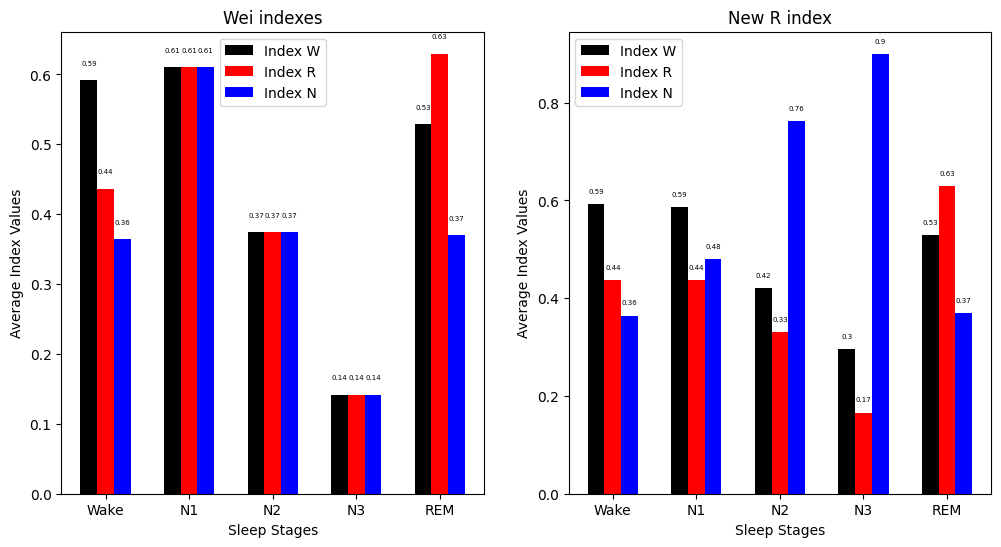

In [169]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'N1', 'N2','N3', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, n1_w, n2_w, n3_w, REM_w]
values_REM = [wake_r, n1_r, n2_r, n3_r, REM_r]
values_NREM = [wake_n, n1_n, n2_n, n3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
fontsize = 5
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom', fontsize=fontsize)

# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'N1', 'N2','N3', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, nn1_w, nn2_w, nn3_w, REM_w]
values_REM = [wake_r, nn1_r, nn2_r, nn3_r, REM_r]
values_NREM = [wake_n, nn1_n, nn2_n, nn3_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New R index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom', fontsize=fontsize)
    
plt.savefig("newrem.svg", format='svg', dpi=300)

#### New NREM (define and get index)

##### Compute new index + function

In [170]:
nindex_n = nindex_N(delta_norm, sigma_norm, gamma_norm)
nindex_n_log = np.log(nindex_n)
nindex_n_norm = wei_normalizing(nindex_n_log)
nindex_n_smoothed = np.convolve(np.convolve(np.convolve(nindex_n_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

In [171]:
nindex_n2 = nindex_N2(delta_norm, theta_norm, sigma_norm, EMG_norm, gamma_norm)
nindex_n2_log = np.log(nindex_n2)
nindex_n2_norm = wei_normalizing(nindex_n2_log)
nindex_n2_smoothed = np.convolve(np.convolve(np.convolve(nindex_n2_norm, np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same'), np.ones(5)/5, mode='same')

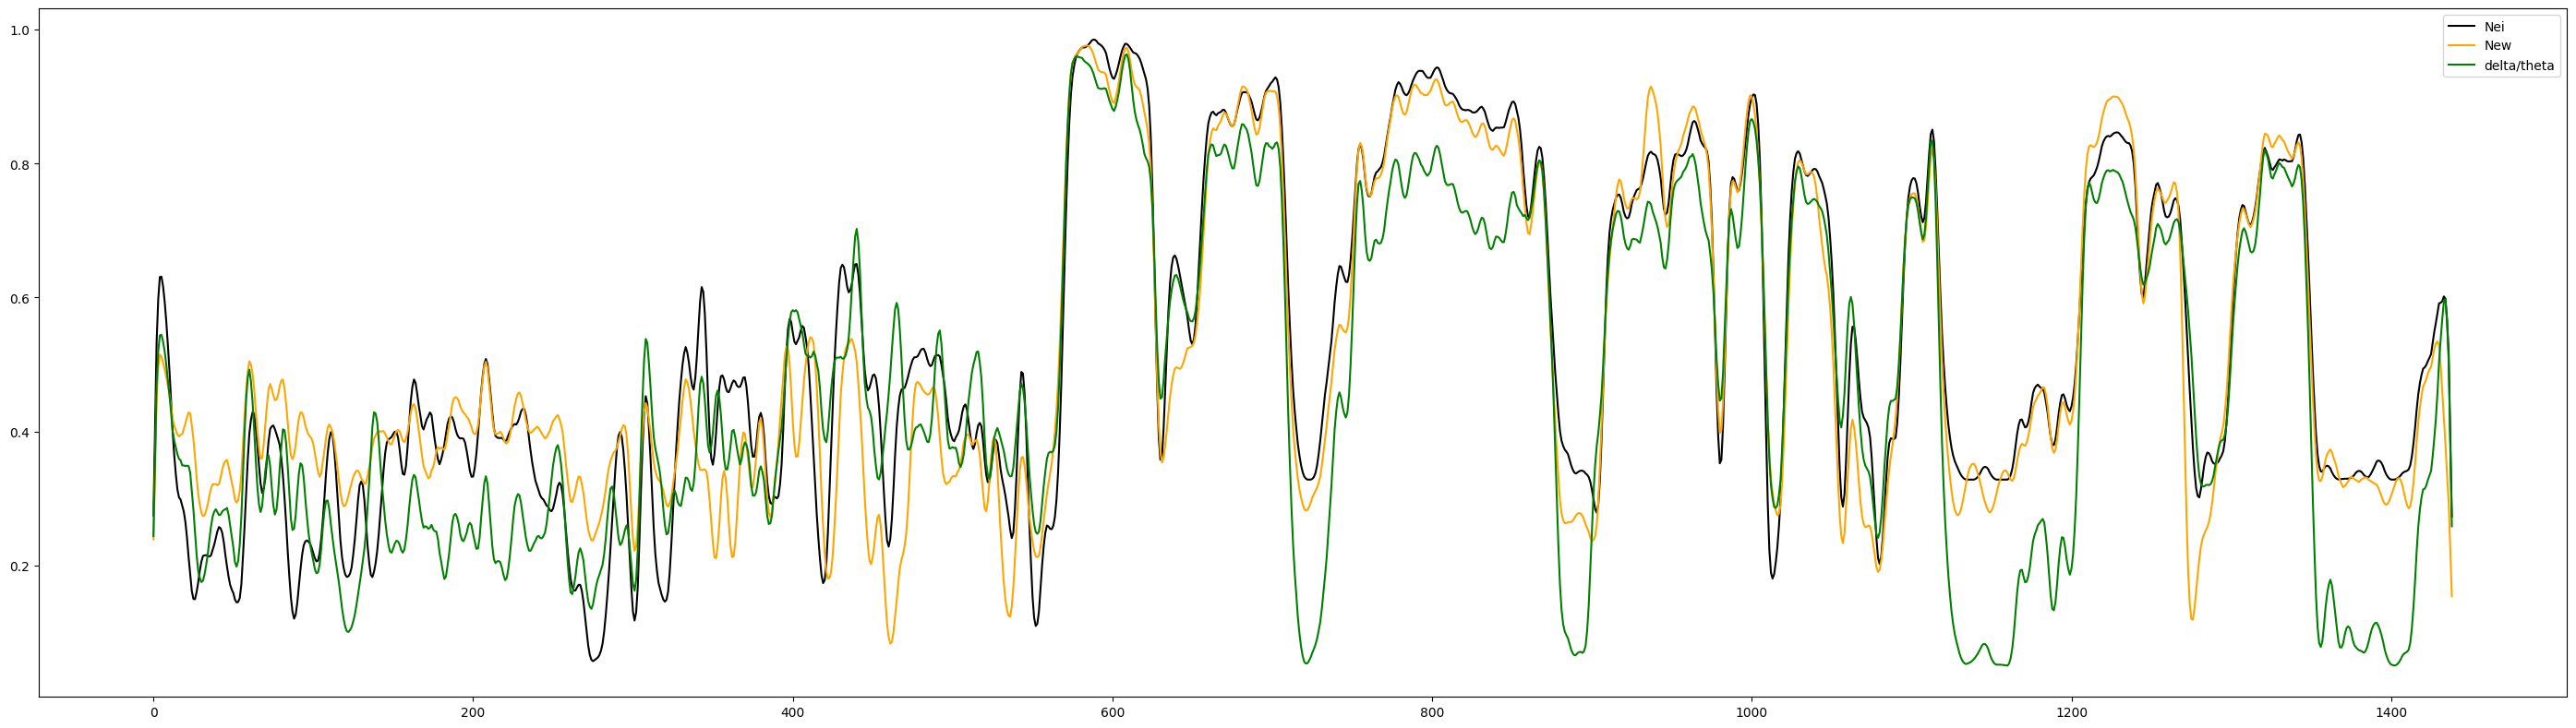

In [173]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, figsize = (28, 8))

# Plot data on each subplot
ax1.plot(epochs, index_n_smoothed, label='Nei', color = 'black')
ax1.plot(epochs, nindex_n_smoothed, label='New', color = 'orange')
ax1.plot(epochs, nindex_n2_smoothed, label='delta/theta', color = 'green')

# Add legendsg
ax1.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("nREMindex.svg", format='svg', dpi=300)
# Show the plots
plt.show()

##### All indices plot

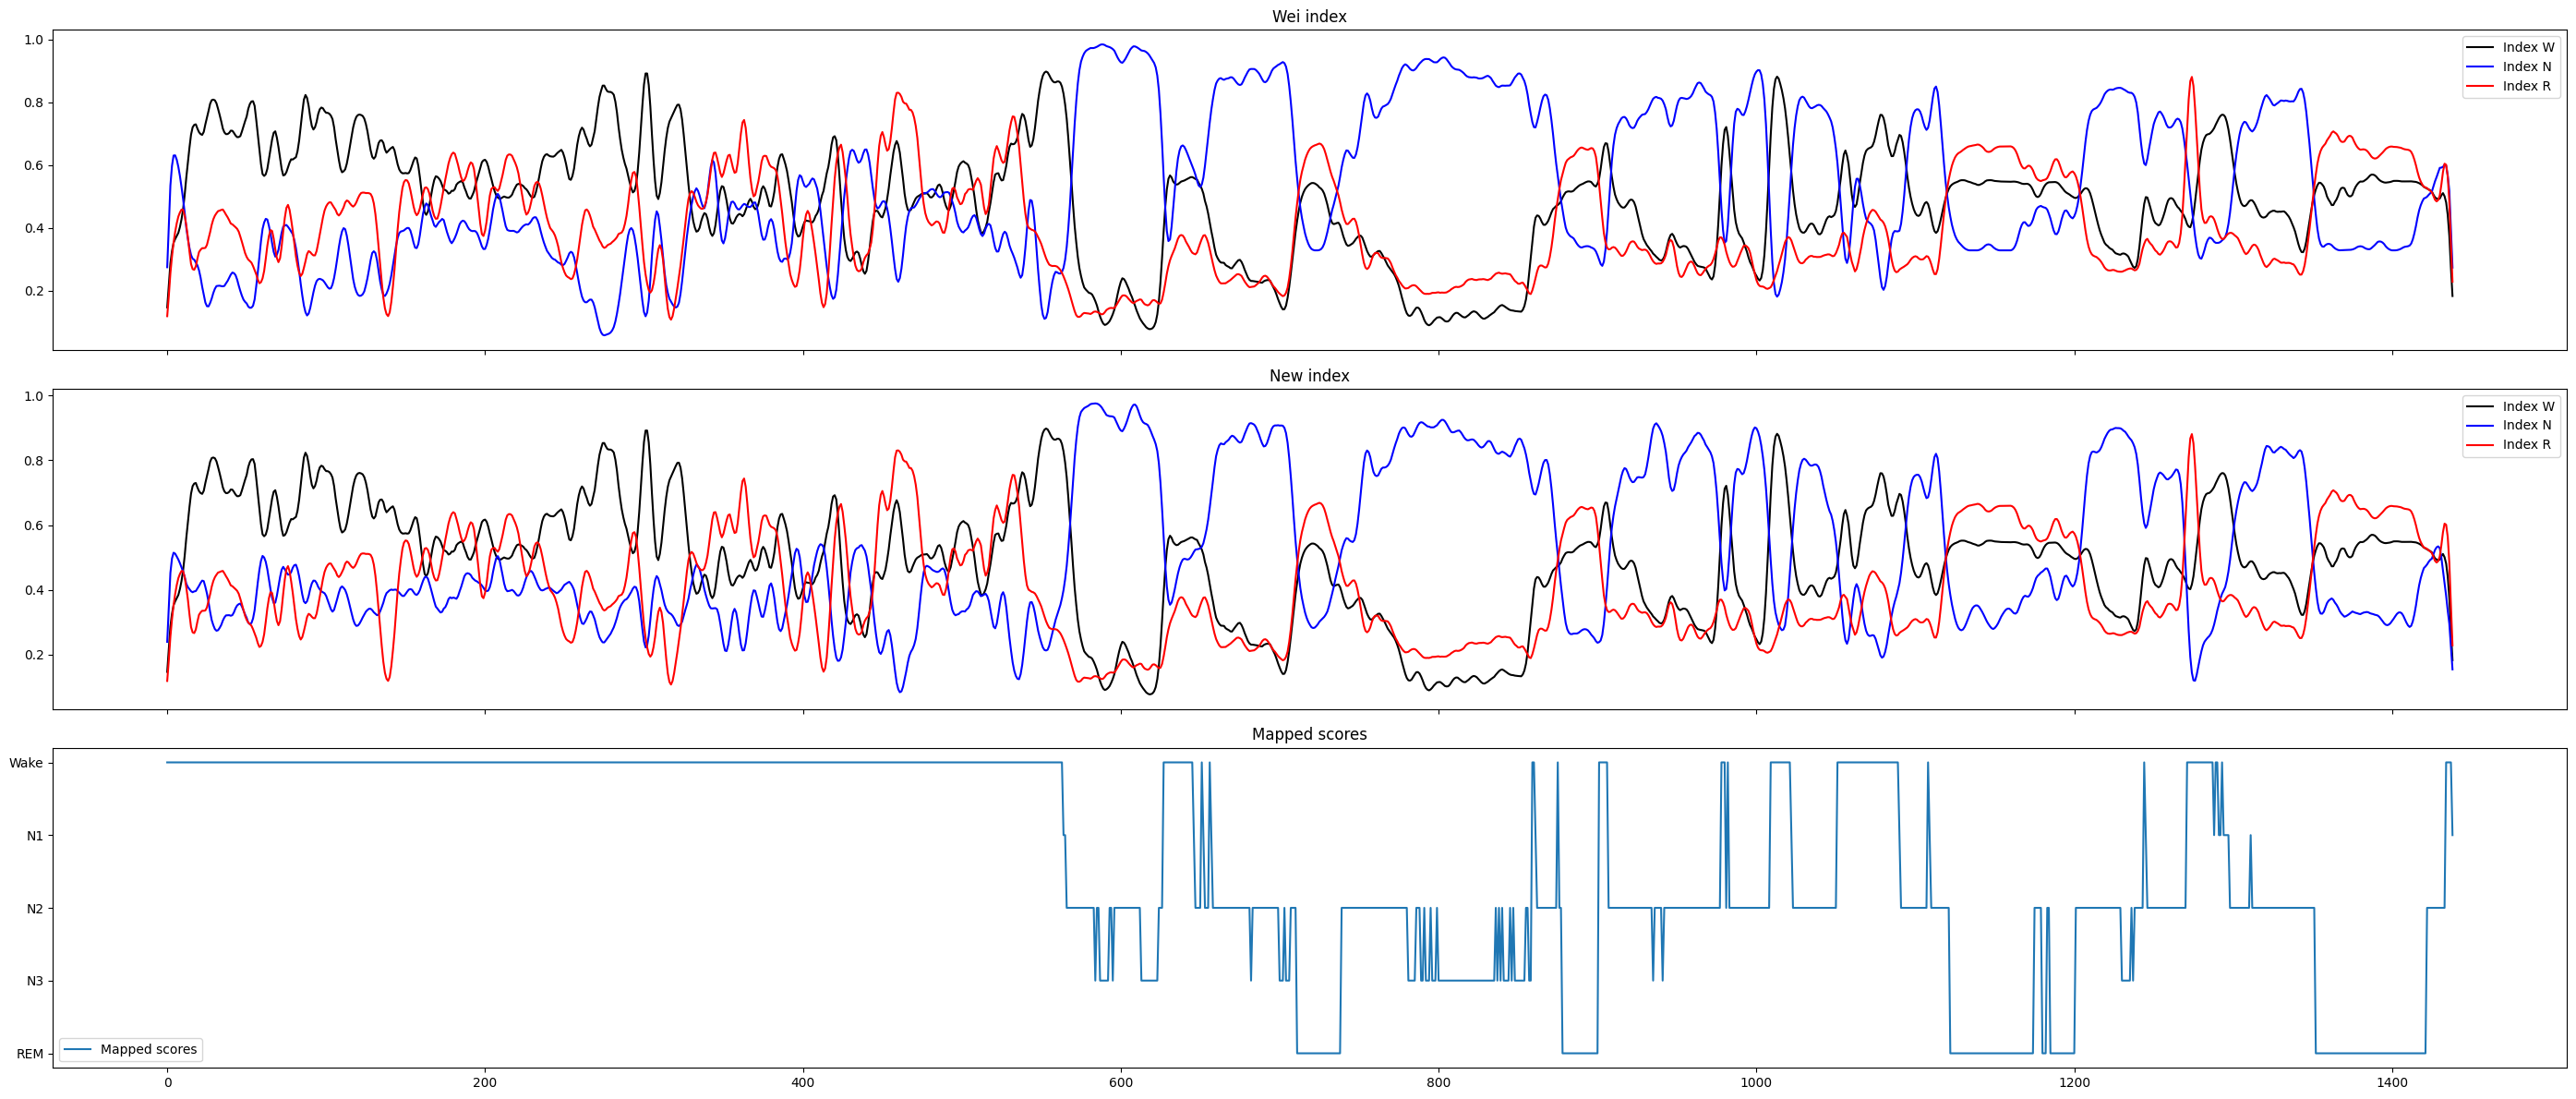

In [175]:
# All indices smoothed for better visualisation

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 12))

# Plot data on each subplot
ax1.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax1.plot(epochs, index_n_smoothed, label='Index N', color ='blue')
ax1.plot(epochs, index_r_smoothed, label='Index R', color ='red')

ax2.plot(epochs, index_w_smoothed, label='Index W', color ='black')
ax2.plot(epochs, nindex_n_smoothed, label='Index N', color ='blue')
ax2.plot(epochs, index_r_smoothed, label='Index R', color ='red')


ax3.plot(epochs, mapped_scores, label='Mapped scores')

# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei index')
ax2.set_title('New index')
ax3.set_title('Mapped scores')
ax3.set_yticks([0, 1, 2, 3, 4])
ax3.set_yticklabels(state_labels)
ax3.invert_yaxis()
# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("allindicesnnrem.svg", format='svg', dpi=300)
# Show the plots
plt.show()

##### Barplots

###### Prerequisites

In [67]:
# Wei
index_Wake = [[],[],[]]
index_NREM = [[],[],[]]
index_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    index_Wake[0].append(index_w_smoothed[i])
    index_Wake[1].append(index_r_smoothed[i])
    index_Wake[2].append(index_n_smoothed[i])

  elif el == 'NREM':
    index_NREM[0].append(index_w_smoothed[i])
    index_NREM[1].append(index_r_smoothed[i])
    index_NREM[2].append(index_n_smoothed[i])
  elif el == 'REM':
    index_REM[0].append(index_w_smoothed[i])
    index_REM[1].append(index_r_smoothed[i])
    index_REM[2].append(index_n_smoothed[i])

# New
nindex_Wake = [[],[],[]]
nindex_NREM = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(index_w_smoothed[i])
    nindex_Wake[1].append(index_r_smoothed[i])
    nindex_Wake[2].append(nindex_n_smoothed[i])

  elif el == 'NREM':
    nindex_NREM[0].append(index_w_smoothed[i])
    nindex_NREM[1].append(index_r_smoothed[i])
    nindex_NREM[2].append(nindex_n_smoothed[i])
  elif el == 'REM':
    nindex_REM[0].append(index_w_smoothed[i])
    nindex_REM[1].append(index_r_smoothed[i])
    nindex_REM[2].append(nindex_n_smoothed[i])

In [68]:
# Wei
wake_w = np.average(index_Wake[0])
wake_r = np.average(index_Wake[1])
wake_n = np.average(index_Wake[2])
NREM_w = np.average(index_NREM[0])
NREM_r = np.average(index_NREM[1])
NREM_n = np.average(index_NREM[2])
REM_w = np.average(index_REM[0])
REM_r = np.average(index_REM[1])
REM_n = np.average(index_REM[2])

# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nNREM_w = np.average(nindex_NREM[0])
nNREM_r = np.average(nindex_NREM[1])
nNREM_n = np.average(nindex_NREM[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

###### Barplots

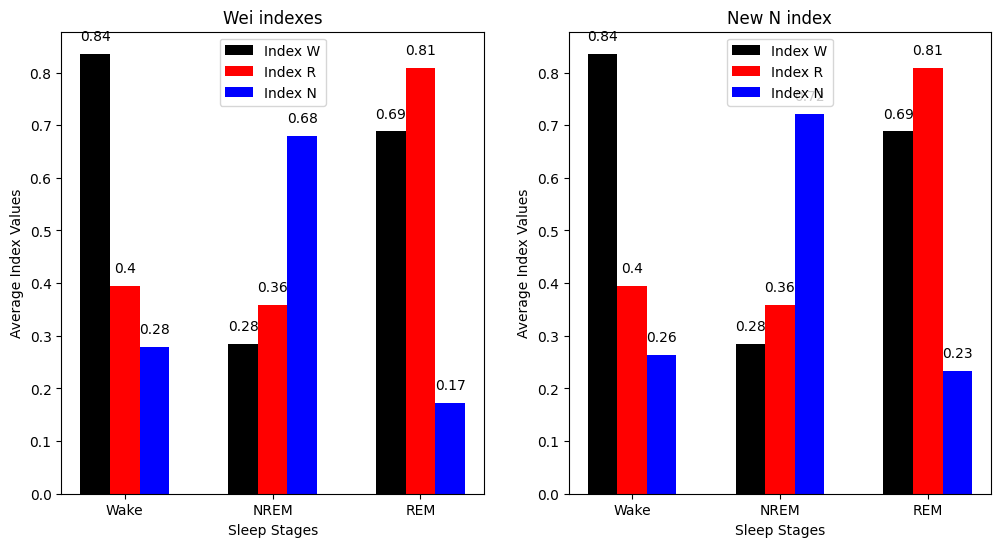

In [69]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'NREM', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, NREM_w, REM_w]
values_REM = [wake_r, NREM_r, REM_r]
values_NREM = [wake_n, NREM_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'NREM', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nNREM_w, nREM_w]
values_REM = [nwake_r, nNREM_r, nREM_r]
values_NREM = [nwake_n, nNREM_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New N index')
plt.xticks(x, categories)
plt.legend()

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')

### Comparing Wei vs New

#### Plot

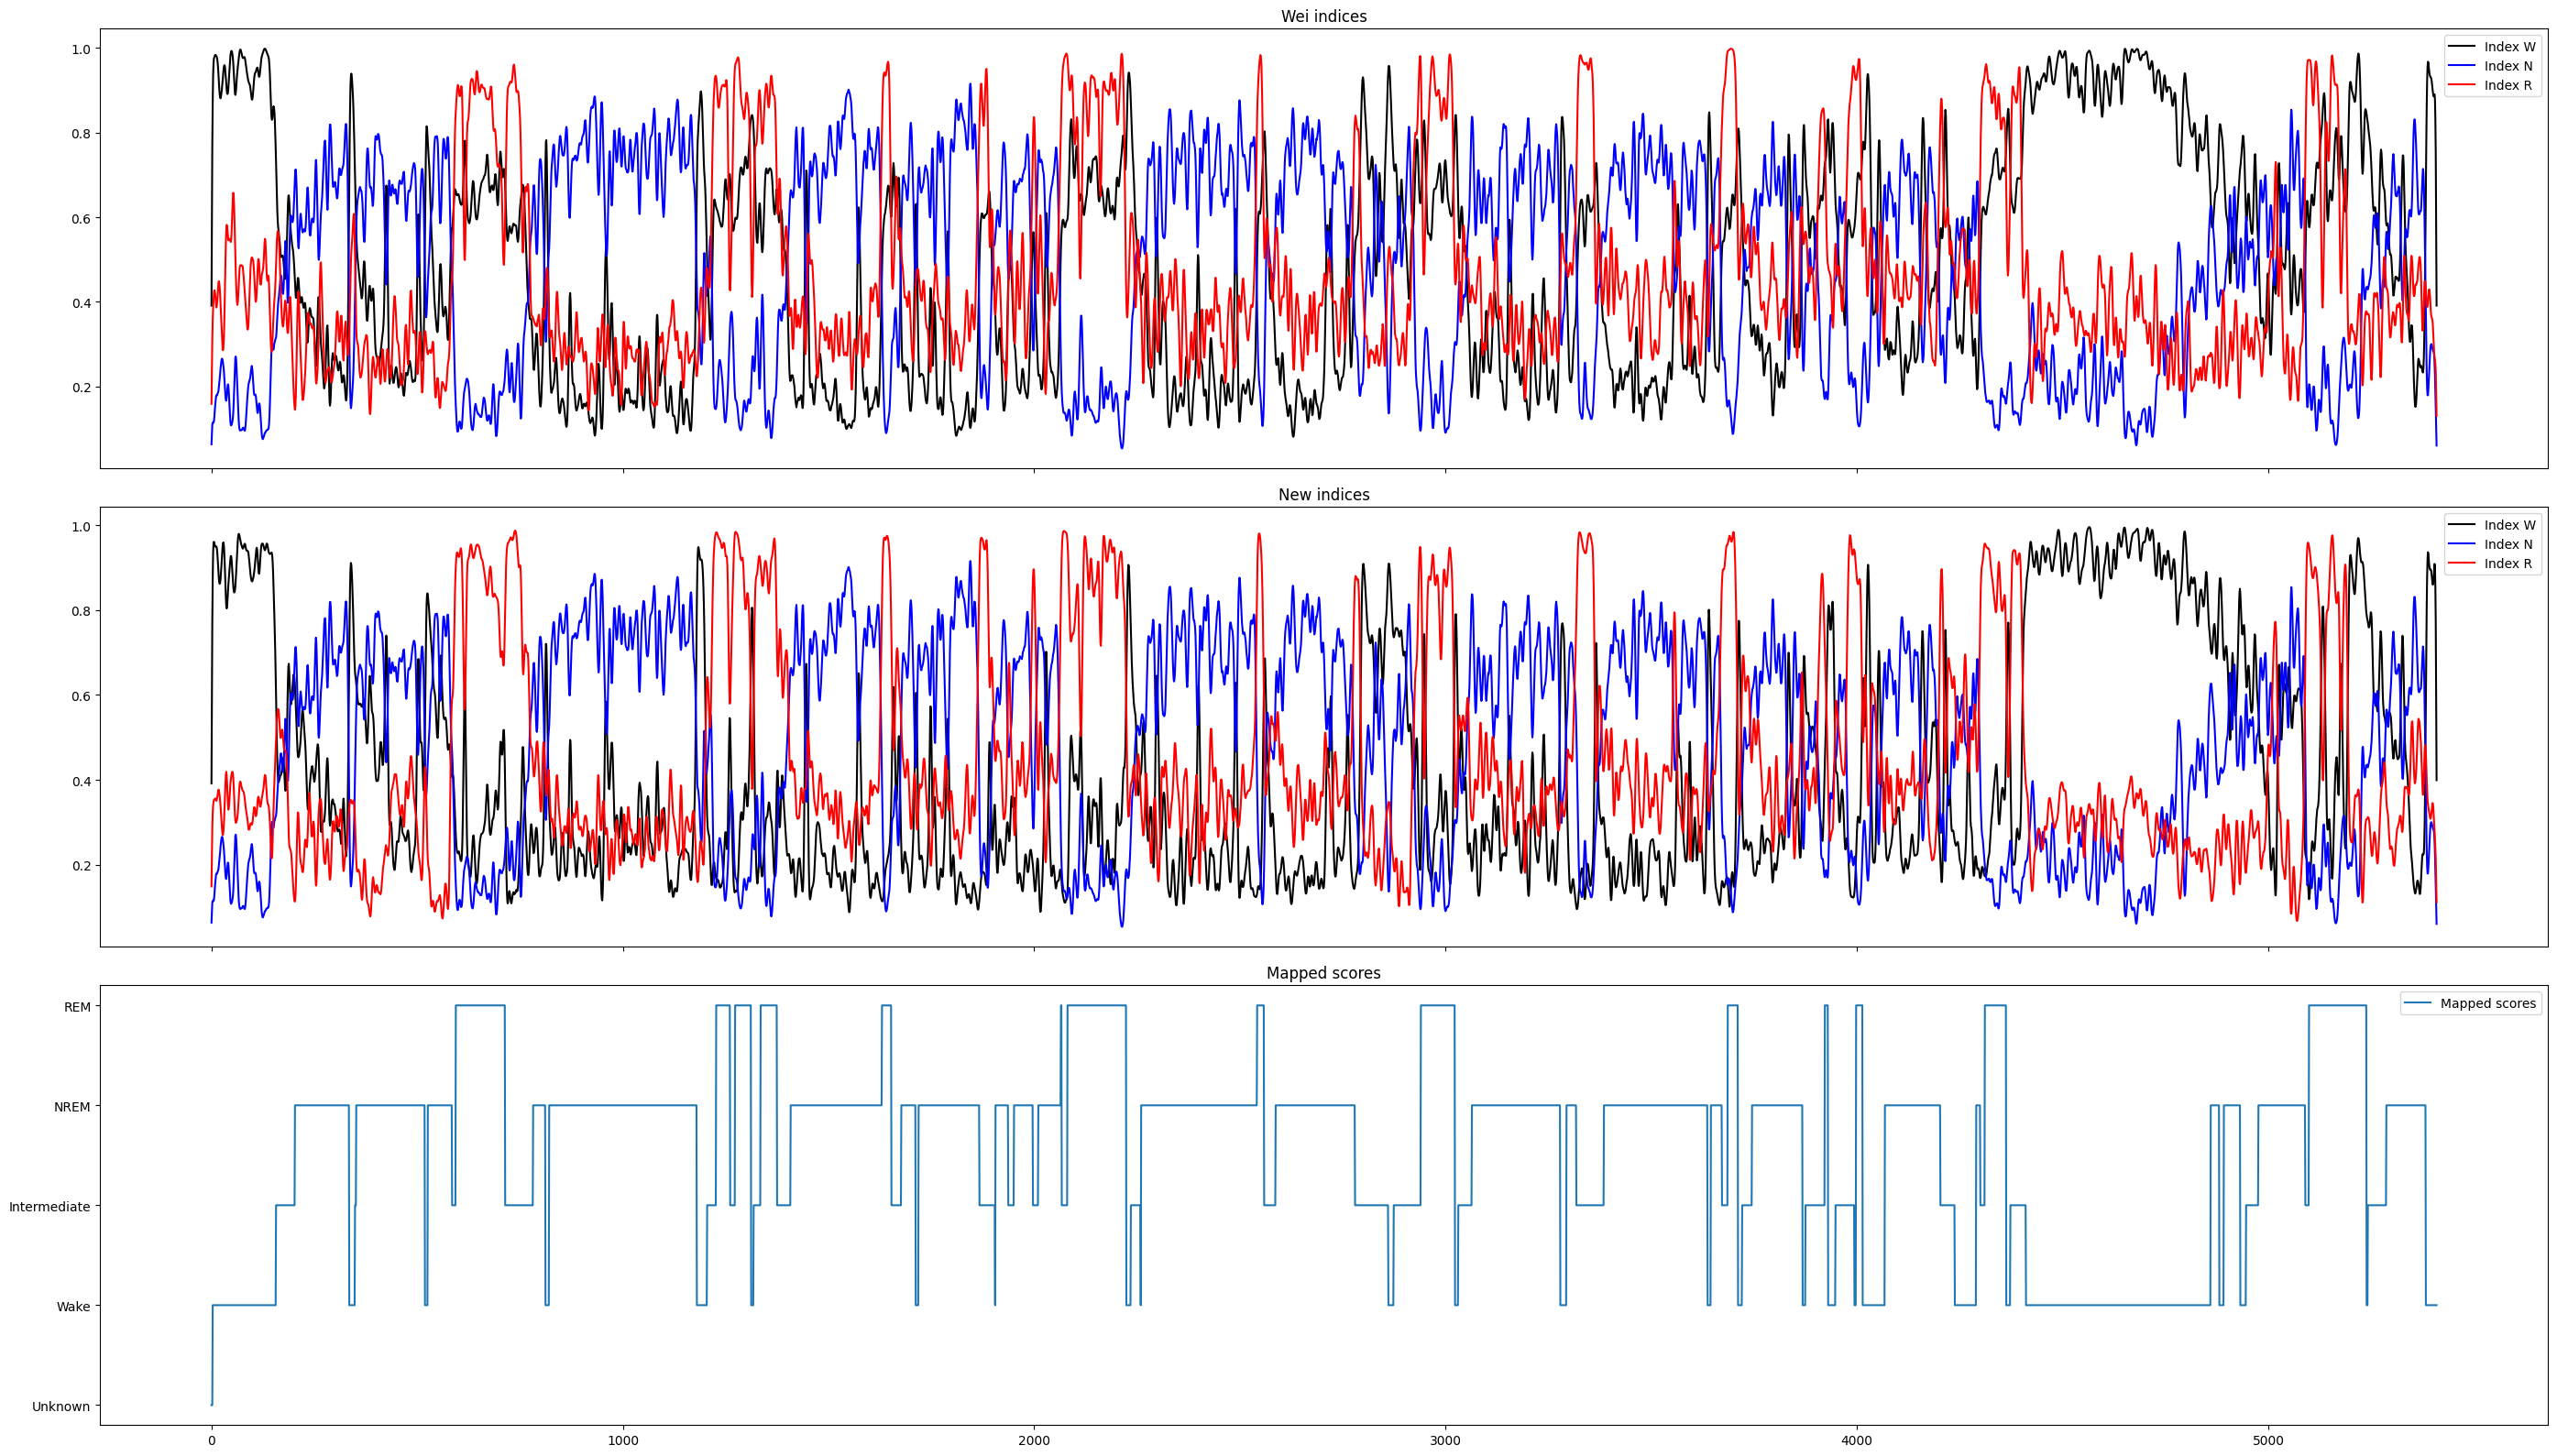

In [70]:
# All main indices
times = np.arange(0, len(epochs))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))

# Plot data on each subplot
ax1.plot(epochs[times], index_w_smoothed[times], label='Index W', color='black')
ax1.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax1.plot(epochs[times], index_r_smoothed[times], label='Index R', color='red')

ax2.plot(epochs[times], nindex_w_smoothed[times], label='Index W', color='black')
ax2.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax2.plot(epochs[times], nindex_r_smoothed[times], label='Index R', color='red')

ax3.plot(epochs[times], mapped_scores[times], label='Mapped scores')



# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei indices')
ax2.set_title('New indices')
ax3.set_title('Mapped scores')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('IndicesPlot.pdf', format='pdf')
# Show the plots
plt.show()

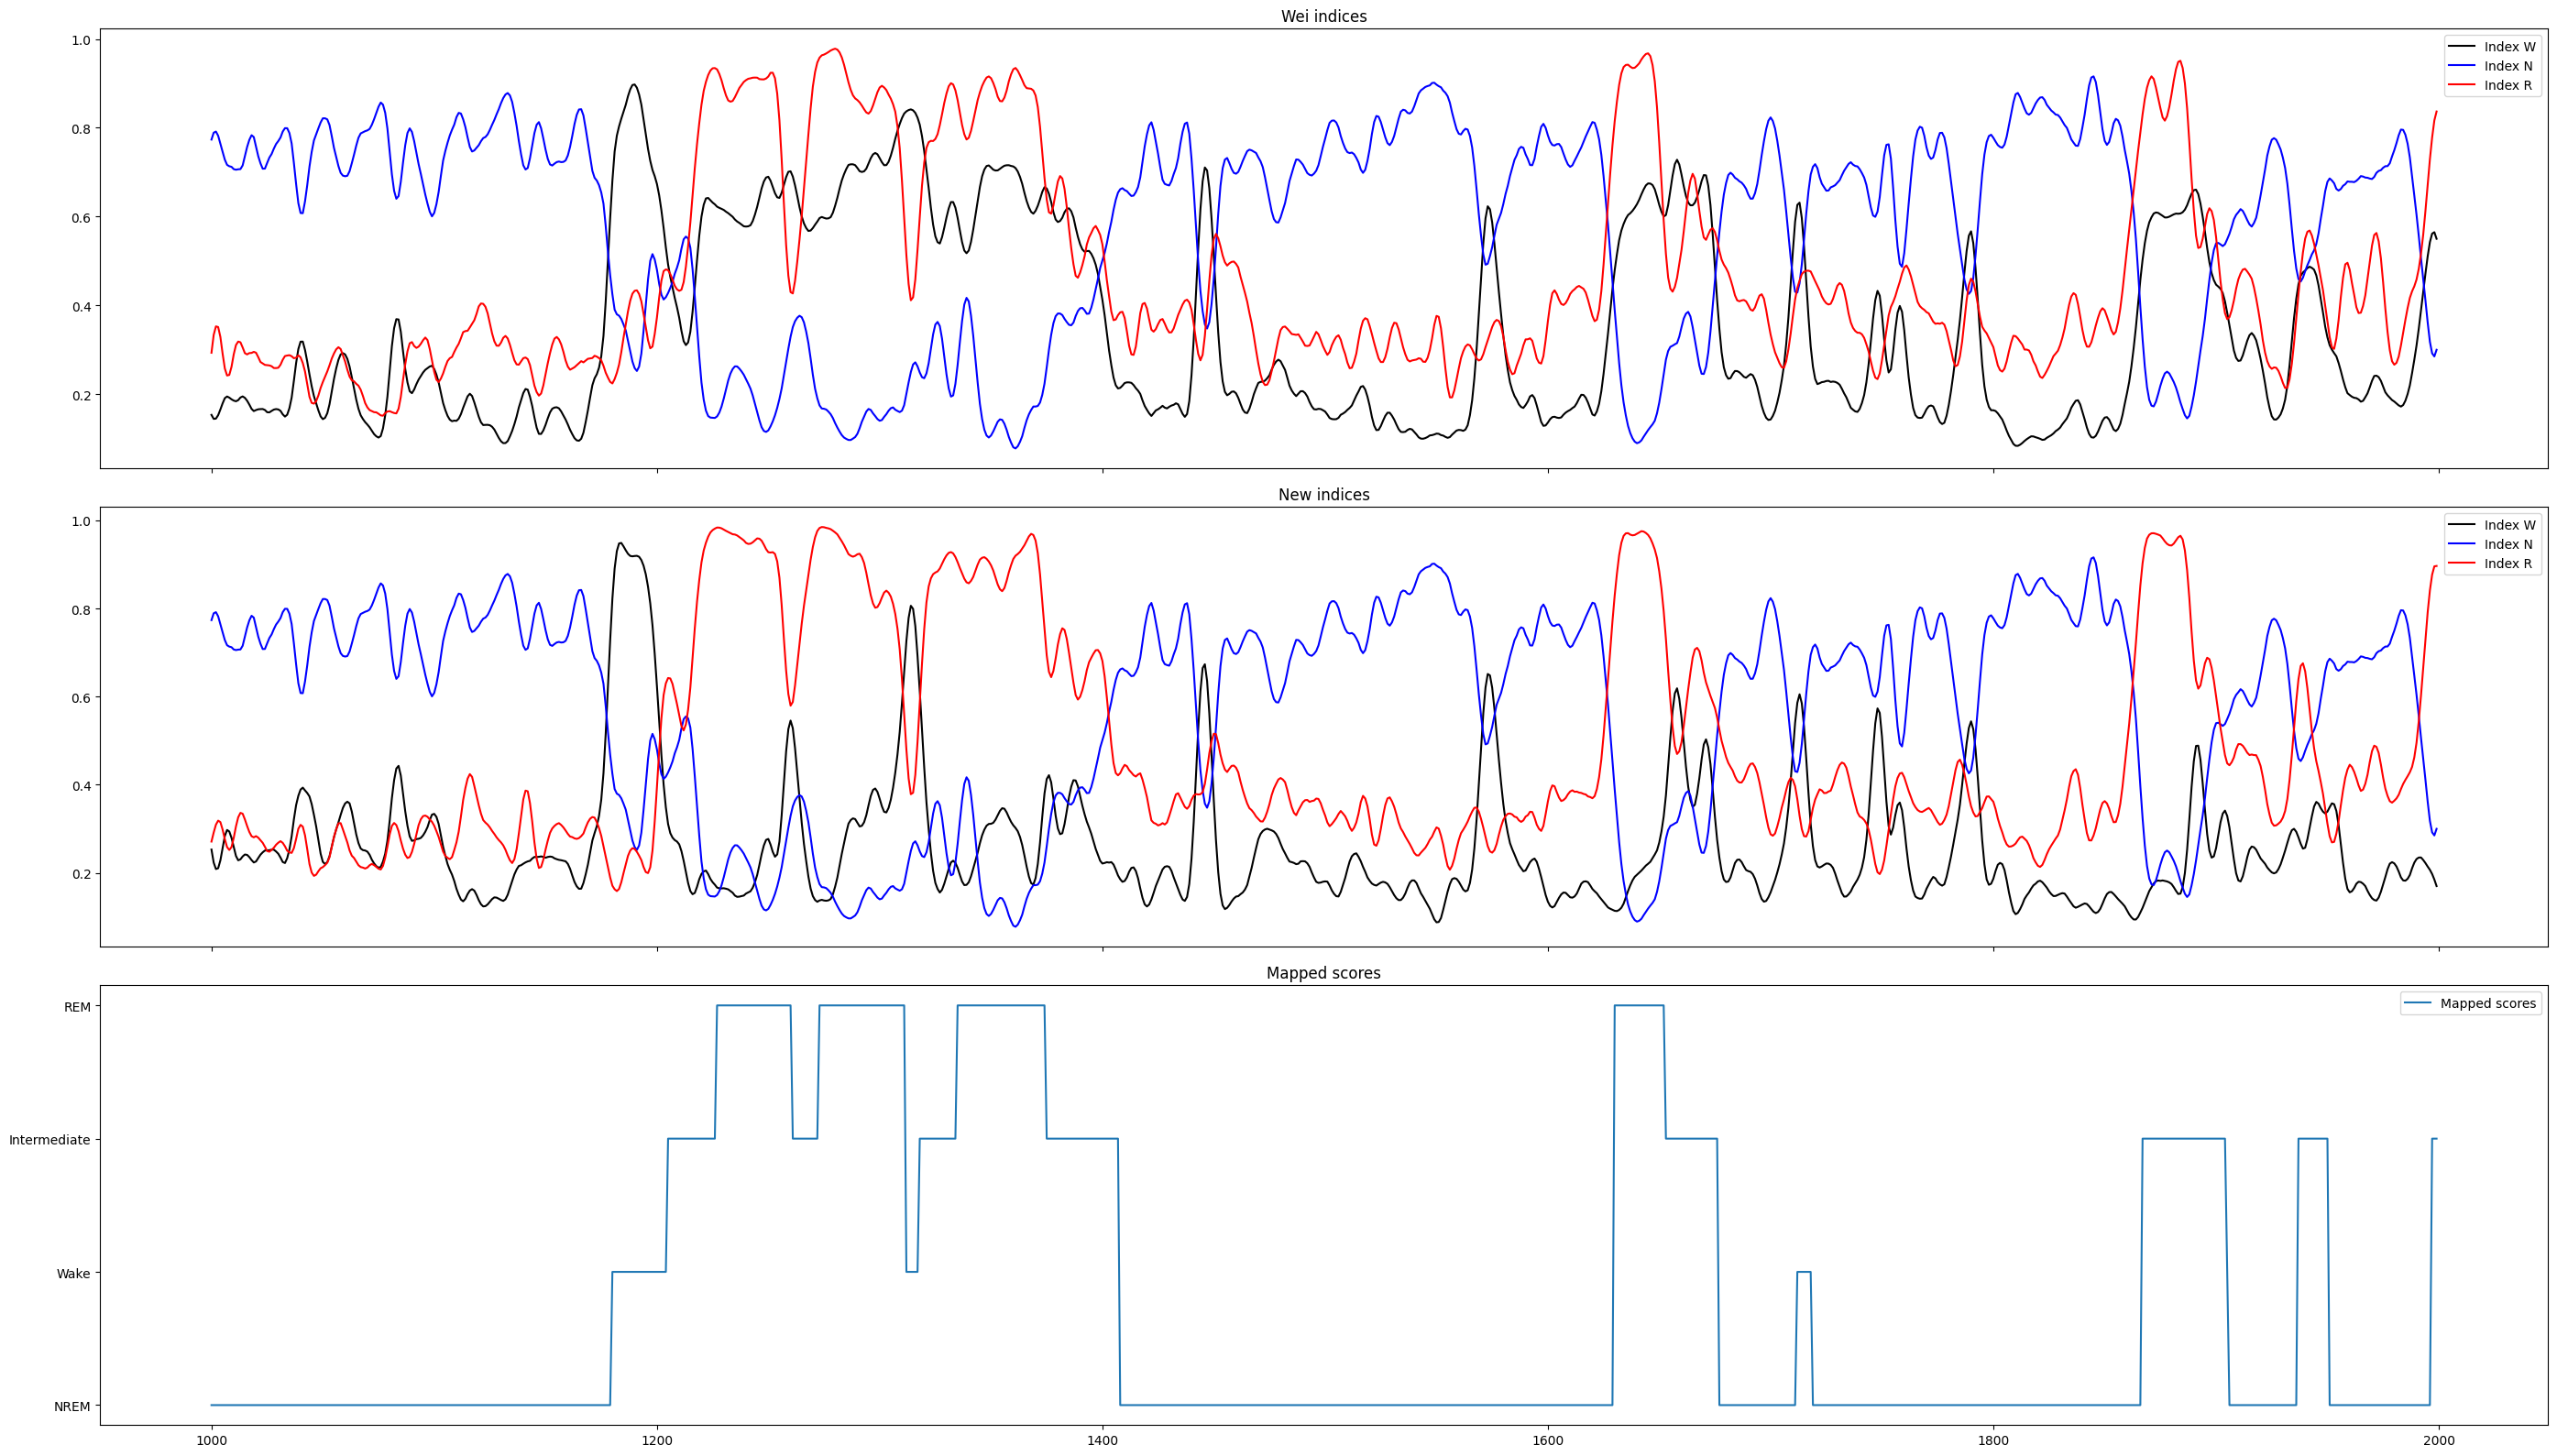

In [76]:
# All main indices
times = np.arange(1000, 2000)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))

# Plot data on each subplot
ax1.plot(epochs[times], index_w_smoothed[times], label='Index W', color='black')
ax1.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax1.plot(epochs[times], index_r_smoothed[times], label='Index R', color='red')

ax2.plot(epochs[times], nindex_w_smoothed[times], label='Index W', color='black')
ax2.plot(epochs[times], index_n_smoothed[times], label='Index N', color='blue')
ax2.plot(epochs[times], nindex_r_smoothed[times], label='Index R', color='red')

ax3.plot(epochs[times], mapped_scores[times], label='Mapped scores')



# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

# Add titles
ax1.set_title('Wei indices')
ax2.set_title('New indices')
ax3.set_title('Mapped scores')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('IndicesPlot.pdf', format='pdf')
# Show the plots
plt.show()

#### Barplots

###### Prerequisites

In [71]:
# Wei
index_Wake = [[],[],[]]
index_NREM = [[],[],[]]
index_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    index_Wake[0].append(index_w_smoothed[i])
    index_Wake[1].append(index_r_smoothed[i])
    index_Wake[2].append(index_n_smoothed[i])

  elif el == 'NREM':
    index_NREM[0].append(index_w_smoothed[i])
    index_NREM[1].append(index_r_smoothed[i])
    index_NREM[2].append(index_n_smoothed[i])
  elif el == 'REM':
    index_REM[0].append(index_w_smoothed[i])
    index_REM[1].append(index_r_smoothed[i])
    index_REM[2].append(index_n_smoothed[i])

# New
nindex_Wake = [[],[],[]]
nindex_NREM = [[],[],[]]
nindex_REM = [[],[],[]]
for i, el in enumerate(mapped_scores):

  if el == 'Wake':
    nindex_Wake[0].append(nindex_w_smoothed[i])
    nindex_Wake[1].append(nindex_r_smoothed[i])
    nindex_Wake[2].append(index_n_smoothed[i])

  elif el == 'NREM':
    nindex_NREM[0].append(nindex_w_smoothed[i])
    nindex_NREM[1].append(nindex_r_smoothed[i])
    nindex_NREM[2].append(index_n_smoothed[i])
  elif el == 'REM':
    nindex_REM[0].append(nindex_w_smoothed[i])
    nindex_REM[1].append(nindex_r_smoothed[i])
    nindex_REM[2].append(index_n_smoothed[i])

In [72]:
# Wei
wake_w = np.average(index_Wake[0])
wake_r = np.average(index_Wake[1])
wake_n = np.average(index_Wake[2])
NREM_w = np.average(index_NREM[0])
NREM_r = np.average(index_NREM[1])
NREM_n = np.average(index_NREM[2])
REM_w = np.average(index_REM[0])
REM_r = np.average(index_REM[1])
REM_n = np.average(index_REM[2])

# New
nwake_w = np.average(nindex_Wake[0])
nwake_r = np.average(nindex_Wake[1])
nwake_n = np.average(nindex_Wake[2])
nNREM_w = np.average(nindex_NREM[0])
nNREM_r = np.average(nindex_NREM[1])
nNREM_n = np.average(nindex_NREM[2])
nREM_w = np.average(nindex_REM[0])
nREM_r = np.average(nindex_REM[1])
nREM_n = np.average(nindex_REM[2])

In [73]:
if 'Wake' not in mapped_scores:
  nwake_w = 0
  nwake_r = 0
  nwake_n = 0
if 'REM' not in mapped_scores:
  nREM_w = 0
  nREM_r = 0
  nREM_n = 0
if 'NREM' not in mapped_scores:
  nNREM_w = 0
  nNREM_r = 0
  nNREM_n = 0

###### Barplots

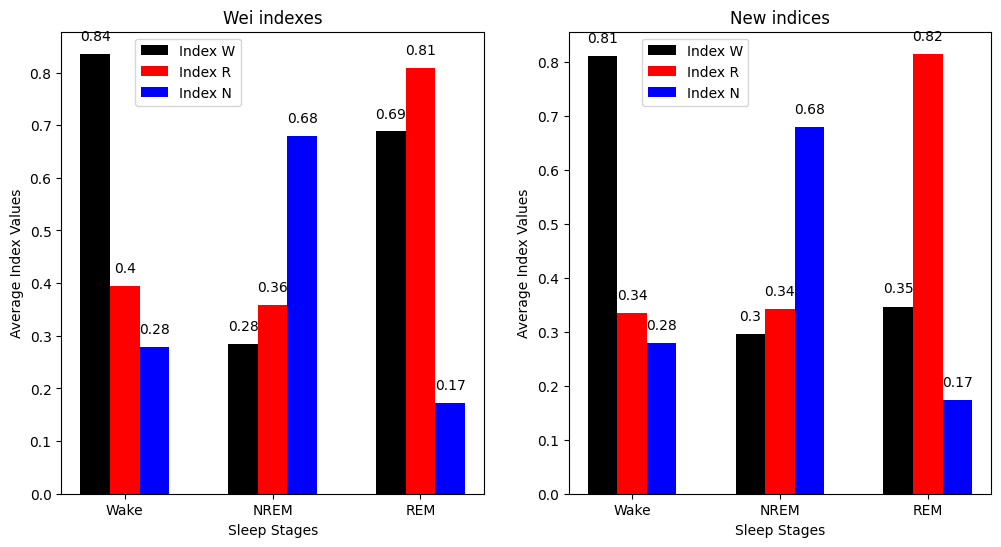

In [74]:
plt.figure(figsize=(12, 6))

# Wei indexes
plt.subplot(1, 2, 1)
categories = ['Wake', 'NREM', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [wake_w, NREM_w, REM_w]
values_REM = [wake_r, NREM_r, REM_r]
values_NREM = [wake_n, NREM_n, REM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('Wei indexes')
plt.xticks(x, categories)
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1))

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')




# New W index
plt.subplot(1, 2, 2)
categories = ['Wake', 'NREM', 'REM']
index_types = ['Index_w', 'Index_r', 'Index_n']
values_wake = [nwake_w, nNREM_w, nREM_w]
values_REM = [nwake_r, nNREM_r, nREM_r]
values_NREM = [nwake_n, nNREM_n, nREM_n]
x = np.arange(len(categories))
bar_width = 0.2
# Create bar plots
plt.bar(x - bar_width, values_wake, width=bar_width, label='Index W', color = 'black')
plt.bar(x, values_REM, width=bar_width, label='Index R', color = 'red',)
plt.bar(x + bar_width, values_NREM, width=bar_width, label='Index N', color = 'blue')
# Add labels and title
plt.xlabel('Sleep Stages')
plt.ylabel('Average Index Values')
plt.title('New indices')
plt.xticks(x, categories)
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1))

for i in range(len(categories)):
    plt.text(x[i] - bar_width, values_wake[i] + 0.02, str(round(values_wake[i], 2)), ha='center', va='bottom')
    plt.text(x[i], values_REM[i] + 0.02, str(round(values_REM[i], 2)), ha='center', va='bottom')
    plt.text(x[i] + bar_width, values_NREM[i] + 0.02, str(round(values_NREM[i], 2)), ha='center', va='bottom')
plt.savefig('Barplots.pdf', format='pdf')
plt.show()

# 3D temporal visualisation of index evolution

In [81]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({
    'summed_emg': savgol_filter(EMG_norm, window_length=101, polyorder=4)[0:1000],               # you want to choose a time interval where you can see a whole wake-nrem-rem-nrem cycle
    'normalized_delta_power': savgol_filter(delta_norm, window_length=101, polyorder=4)[0:1000],  # extra smoothing so that we can actullay see something
    'normalized_theta_power': savgol_filter(theta_norm, window_length=101, polyorder=4)[0:1000]
})

fig = px.scatter_3d(df, x='normalized_theta_power', y='normalized_delta_power', z='summed_emg',
                    title='',
                    color=df.index,
                    color_continuous_scale='Magma',
                    opacity=0.8)

fig.update_layout(width=1000, height=900)
fig.show()